In [3]:
from Basics import *
setplot(dark=True)

# Mass Conversions

In [153]:
np.log10(massconv(cosmo, 10**logmshalo, 1/(1+zs[1])))

array([10.03866895, 10.12058278, 10.20250223, 10.28442744, 10.36635854,
       10.44829568, 10.530239  , 10.61218865, 10.69414477, 10.77610752,
       10.85807705, 10.94005349, 11.02203701, 11.10402773, 11.1860258 ,
       11.26803135, 11.35004453, 11.43206545, 11.51409425, 11.59613102,
       11.67817586, 11.76022883, 11.84228999, 11.92435939, 12.00643703,
       12.0885229 , 12.17061694, 12.25271906, 12.33482911, 12.41694688,
       12.49907214, 12.58120453, 12.66334366, 12.74548901, 12.82763995,
       12.90979575, 12.99195552, 13.07411823, 13.15628267, 13.23844742,
       13.32061086, 13.40277109, 13.48492597, 13.56707305, 13.64920953,
       13.73133229, 13.81343779, 13.89552212, 13.9775809 , 14.05960933])

In [156]:
import pyccl

pyccl.halos.concentration.diemer15

# pyccl.halos.concentration.ConcentrationDiemer15.

cosmo = pyccl.Cosmology(h=0.7, Omega_c=0.25, Omega_b=0.044, n_s=0.95, sigma8=0.8,transfer_function='bbks')

massconv = pyccl.halos.massdef.mass_translator(mass_in='200c', mass_out='vir',
                                    concentration='Diemer15')

logmshalo = np.linspace(10, 14, 50)
zs = np.linspace(0.4, 1.1, 10)
np.array([np.log10(massconv(cosmo, 10**logmshalo, 1/(1+z))) for z in zs]).shape


(10, 50)

# HOD Stuff

In [2]:
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}
logmshalo = np.linspace(10, 14, 50)
zs = np.linspace(0.4, 1.1, 10)
rs = np.logspace(-1.5, 1.5, 100)

cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=2.726, Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])
rhoc_func = lambda z: cosmology.critical_density(z).to(u.Msun/u.Mpc**3).value
r200c_func = lambda z, logm200c: (10**logm200c/(4/3*np.pi*200*rhoc_func(z[:, None])))**(1/3)
H_func = lambda z: cosmology.H(z).to(u.km/u.s/u.Mpc).value
chi_func = lambda z: cosmology.comoving_distance(z).value

rhocs = rhoc_func(zs)
rs200c = r200c_func(zs, logmshalo)
Hs = H_func(zs)
chis = chi_func(zs)

In [ ]:
import Models.FFTs as FFTs
ks, FFT_func = FFTs.mcfit_package(rs).FFT3D()
rs_rev, IFFT_func = FFTs.mcfit_package(rs).IFFT3D()
rs_rev, IFFT1D_func = FFTs.mcfit_package(rs).IFFT1D()
rs_rev, IFFT2D_func = FFTs.mcfit_package(rs).IFFT2D()


import Capybara.Models.HaloModels as HaloModels
hmfccl = HaloModels.pyccl({'mdef':'200c', 'mfunc':'Tinker08', 'hbias':'Tinker10'})
Pklin = hmfccl.Plin(ks, zs, **cpars)
bias = hmfccl.bh(zs, logmshalo, **cpars)
hmf = hmfccl.HMF(zs, logmshalo, **cpars)

import Models.HODs as HODs
importlib.reload(HODs)

Kou = HODs.Kou2023({'sample':'M*>10.8'})

import Models.Profiles as Profiles
importlib.reload(Profiles)

AmodeoPth_1h = Profiles.Amodeo2021({'model':'GNFW'}).Pth1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)


In [112]:
np.trapz(hmf, logmshalo)

array([0.11853385, 0.11918056, 0.11983307, 0.12045879, 0.1211881 ,
       0.12197017, 0.12263032, 0.12315773, 0.12354447, 0.12378477])

In [110]:
import Models.Spectra as Spectra
importlib.reload(Spectra)

Nc = Kou.Nc(logmshalo)()
Ns = Kou.Ns(logmshalo)()
uck = Kou.uck()
usk = Kou.usk(rs, rs200c, FFT_func)()
y_k = Spectra.y_k(FFT_func, **cpars)(AmodeoPth_1h())

Pgy = Spectra.Pgy1h(logmshalo, hmf, y_k, Hs, Nc, Ns, uck, usk)

zdist = scipy.stats.norm.pdf(zs, loc=0.5, scale=0.1) 
ells = np.geomspace(50, 10000, 100)
C_ells = Spectra.limber(ks, zs, Spectra.W_g(zdist), Spectra.W_y(zs), Hs, chis, ells)

test1 = Spectra.HODweighting(zs, logmshalo, hmf, FFT_func, IFFT1D_func,zdist)(AmodeoPth_1h(), H_g=Spectra.H_g(Nc, Ns, uck, usk, logmshalo, hmf))
test2 = Spectra.HODweighting(zs, logmshalo, hmf, FFT_func, IFFT1D_func, zdist,H_g=Spectra.H_g(Nc, Ns, uck, usk, logmshalo, hmf))(AmodeoPth_1h())

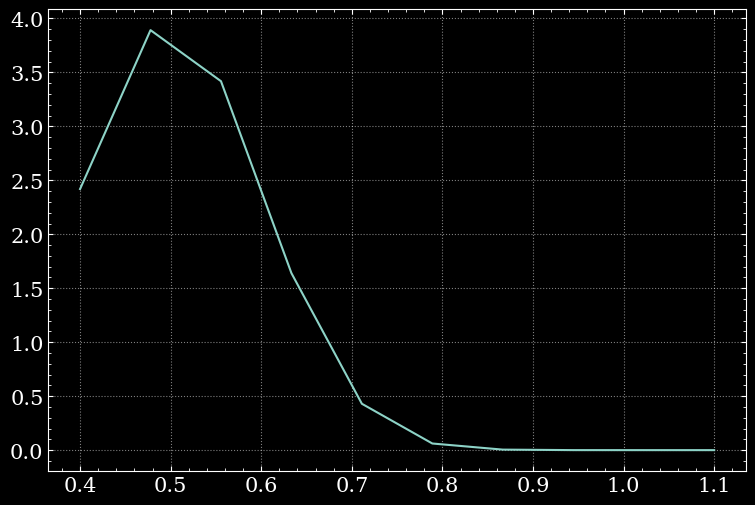

In [ ]:
plt.plot(rs, zdist)

In [80]:
np.average(zs, weights=zdist)

0.5160510474756798

In [85]:
zs[1]-zs[0]

0.07777777777777778

In [88]:
np.trapz(zdist)/(zs[1]-zs[0])

137.02050825479245

In [65]:
AmodeoPth_1h()

array([[[5.94907761e-16, 7.34451368e-16, 9.05325955e-16, ...,
         2.79282886e-12, 3.26599517e-12, 3.81720890e-12],
        [6.80375105e-16, 8.39770435e-16, 1.03490635e-15, ...,
         3.16783703e-12, 3.70422274e-12, 4.32904350e-12],
        [7.76724096e-16, 9.58527480e-16, 1.18105607e-15, ...,
         3.59466179e-12, 4.20305719e-12, 4.91172671e-12],
        ...,
        [1.45772703e-15, 1.79852669e-15, 2.21557038e-15, ...,
         6.69347157e-12, 7.82570769e-12, 9.14447555e-12],
        [1.64135248e-15, 2.02515985e-15, 2.49485193e-15, ...,
         7.54686085e-12, 8.82357502e-12, 1.03106388e-11],
        [1.84343005e-15, 2.27461809e-15, 2.80232415e-15, ...,
         8.49274380e-12, 9.92967543e-12, 1.16033794e-11]],

       [[5.38545363e-16, 6.66041165e-16, 8.22452024e-16, ...,
         2.69305877e-12, 3.15140415e-12, 3.68562042e-12],
        [6.16079004e-16, 7.61753286e-16, 9.40421685e-16, ...,
         3.05498003e-12, 3.57460472e-12, 4.18020296e-12],
        [7.03460176e-16, 

In [54]:
''*zdist

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


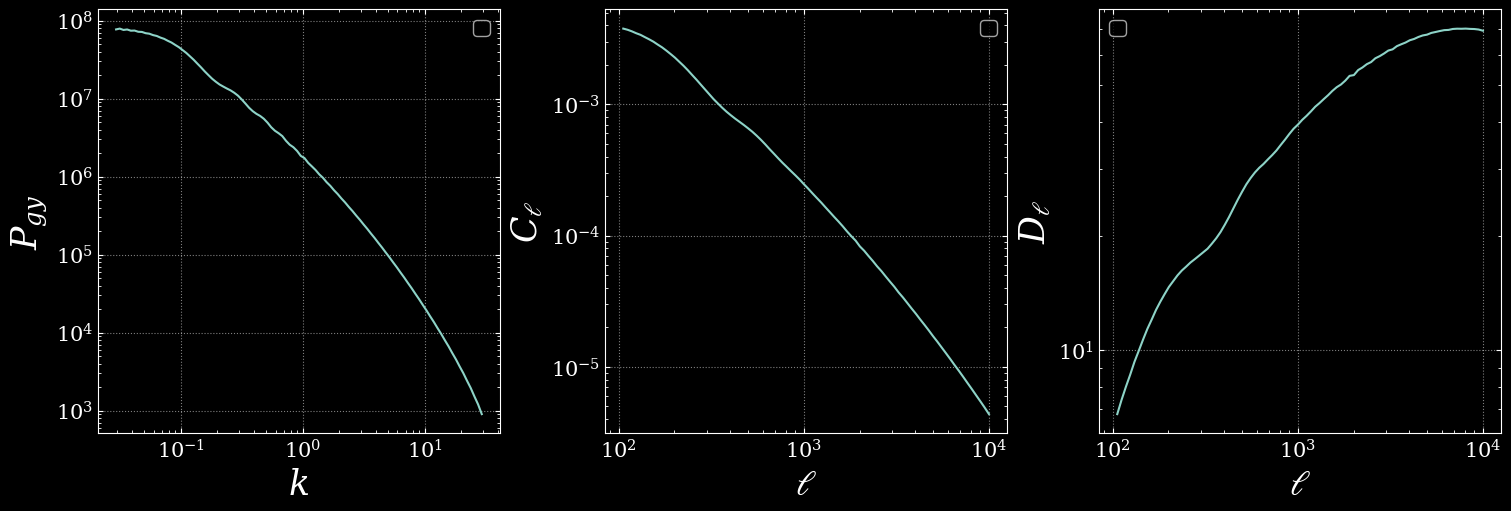

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

axs[0].loglog(ks, Pgy[:,4])

axs[1].loglog(ells, C_ells(Pgy))

axs[2].loglog(ells, ells*(ells+1)*C_ells(Pgy)/2/np.pi)

axs[0].set(xlabel=r'$k$', ylabel=r'$P_{gy}$'); axs[0].legend()
axs[1].set(xlabel=r'$\ell$', ylabel=r'$C_\ell$'); axs[1].legend()
axs[2].set(xlabel=r'$\ell$', ylabel=r'$D_\ell$'); axs[2].legend()

plt.show()

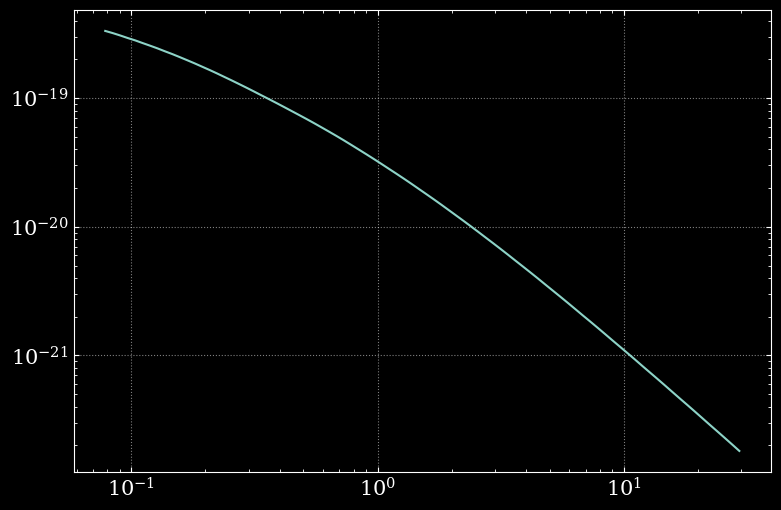

In [ ]:
plt.loglog(ks, C_ells(Spectra.cross1h(logmshalo, hmf, Hg(), Hy())))

In [21]:
scipy.stats.norm.pdf(zs, loc=0.5, scale=0.1) 

array([2.41970725e+00, 3.89212469e+00, 3.41892294e+00, 1.64010075e+00,
       4.29665405e-01, 6.14708041e-02, 4.80270652e-03, 2.04918821e-04,
       4.77481223e-06, 6.07588285e-08])

In [94]:
(FFTs.mcfit_package(np.logspace(-1, 1)).FFT3D()[0][:, None]*chis).min()

141.23376745293623

In [97]:
lmin, lmax, nell = 100, 10000, 20

ells_from_ks = ks[:, None]*chis
ell_min = np.max([lmin, (ells_from_ks.min()//10 + 1)*10])
ell_max = np.min([lmax, (ells_from_ks.max() // 1e3)*1e3])
ells = np.geomspace(ell_min, ell_max, nell)
ks_from_ells = ells[:, None]/chis

tupletest = np.stack((ks_from_ells, zs*np.ones(ks_from_ells.shape)), axis=-1)

intp = RegularGridInterpolator((ks, zs), thing, bounds_error=False, fill_value=0)

intp(tupletest).shape

(20, 10)

In [61]:
np.trapz(intp(tupletest), axis=1)

array([0.00000000e+00, 0.00000000e+00, 4.23821249e-09, 2.88724028e-08,
       4.93262550e-08, 6.02242491e-08, 4.90152115e-08, 3.86836295e-08,
       2.94871856e-08, 2.17246743e-08, 1.55518354e-08, 1.08581948e-08,
       7.36846458e-09, 4.82999538e-09, 3.07337081e-09, 1.89788283e-09,
       1.14100612e-09, 6.69578555e-10, 3.84810880e-10, 2.17322793e-10])

# Dust

In [4]:
x500 = np.array([1.63, 1.75, 1.84, 1.94, 2.07, 2.20, 2.29, 2.41, 2.52, 2.66,
    2.78, 2.89, 3.00, 3.23, 3.37, 3.50, 3.69, 3.85, 3.99, 4.18,
    4.38, 4.51, 4.69, 4.83, 5.01, 5.23, 5.48, 5.77, 5.96])

y500 = np.array([1.25, 1.20, 1.15, 1.10, 1.04, 0.973, 0.934, 0.880, 0.835, 0.778,
    0.730, 0.682, 0.646, 0.566, 0.518, 0.470, 0.419, 0.371, 0.333, 0.285,
    0.240, 0.214, 0.176, 0.154, 0.131, 0.0992, 0.0704, 0.0480, 0.0384])

x350 = np.array([1.66, 1.82, 2.01, 2.19, 2.37, 2.59, 2.75, 3.00, 3.23, 3.40,
    3.61, 3.79, 4.00, 4.19, 4.36, 4.50, 4.69, 4.90, 5.09, 5.34,
    5.59, 5.93])

y350 = np.array([1.76, 1.65, 1.51, 1.39, 1.28, 1.15, 1.06, 0.921, 0.804, 0.720,
    0.630, 0.556, 0.476, 0.407, 0.354, 0.312, 0.254, 0.206, 0.169, 0.122,
    0.0926, 0.0582])

x250 = np.array([1.63, 1.84, 2.03, 2.23, 2.48, 2.67, 2.86, 3.07, 3.25, 3.46,
    3.64, 3.84, 4.03, 4.26, 4.56, 4.87, 5.10, 5.36, 5.66, 5.97])

y250 = np.array([1.70, 1.56, 1.44, 1.30, 1.16, 1.05, 0.945, 0.847, 0.760, 0.656,
    0.585, 0.508, 0.443, 0.361, 0.273, 0.197, 0.153, 0.104, 0.0765, 0.0437])

x500h = np.array([1.64, 1.77, 1.88, 2.03, 2.17, 2.34, 2.50, 2.63, 2.79, 2.98,
     3.15, 3.35, 3.54, 3.70, 3.87, 4.10, 4.31, 4.53, 4.72, 4.92,
     5.10, 5.30, 5.52, 5.74, 5.96])

y500h = np.array([0.966, 0.923, 0.881, 0.830, 0.779, 0.725, 0.674, 0.634, 0.586, 0.535,
     0.495, 0.444, 0.396, 0.365, 0.328, 0.279, 0.245, 0.211, 0.180, 0.157,
     0.140, 0.115, 0.101, 0.0837, 0.0723])

x350h = np.array([1.65, 1.78, 1.95, 2.09, 2.24, 2.38, 2.54, 2.70, 2.89, 3.07,
     3.26, 3.46, 3.61, 3.78, 3.95, 4.12, 4.30, 4.50, 4.68, 4.92,
     5.11, 5.37, 5.60, 5.79, 5.99])

y350h = np.array([1.62, 1.54, 1.45, 1.36, 1.27, 1.20, 1.11, 1.04, 0.941, 0.863,
     0.784, 0.701, 0.642, 0.588, 0.520, 0.461, 0.417, 0.363, 0.319, 0.265,
     0.230, 0.181, 0.157, 0.137, 0.113])

x250h = np.array([1.63, 1.83, 2.01, 2.24, 2.44, 2.62, 2.81, 3.02, 3.26, 3.47,
     3.66, 3.89, 4.12, 4.37, 4.62, 4.87, 5.09, 5.34, 5.60, 5.84, 5.99])

y250h = np.array([1.98, 1.85, 1.72, 1.55, 1.42, 1.31, 1.19, 1.08, 0.954, 0.847,
     0.765, 0.663, 0.571, 0.485, 0.398, 0.332, 0.281, 0.224, 0.189, 0.153, 0.143])


roughdustx150 = np.array([1.64, 1.78, 1.93, 2.10, 2.26, 2.49, 2.68, 2.94, 3.18, 3.37,
    3.58, 3.82, 4.07, 4.34, 4.66, 4.91, 5.10, 5.29, 5.62, 5.85, 5.98])

roughdusty150 = np.array([1.07, 1.20, 1.32, 1.50, 1.60, 1.71, 1.79, 1.88, 1.84, 1.88,
    1.82, 1.71, 1.58, 1.41, 1.15, 0.940, 0.812, 0.598, 0.427, 0.256, 0.171])


roughdustx90 = [1.66, 1.79, 1.95, 2.08, 2.27, 2.57, 2.85, 3.16, 3.60, 3.87, 4.16, 4.42, 4.74, 5.08, 5.37, 5.80, 5.99]
roughdusty90 = [0.494, 0.432, 0.556, 0.617, 0.679, 0.741, 0.802, 0.802, 0.802, 0.679, 0.679, 0.617, 0.432, 0.309, 0.185, 0.123, 0.0617]

In [27]:
# 250~1200, 350~856, 500~600

import Models.Dust as Dust
importlib.reload(Dust)

cpars = {"hh": 0.71, "Omega_L":0.732, "Omega_m":0.268, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}
thetas = np.linspace(0, 6, 10)

AmodeodustAH = Dust.Amodeo2021({'model':'ACT+Hershel'})
AmodeodustH = Dust.Amodeo2021({'model':'Hershel'})

xdatalistAH, xdatalistH = [x500, x350, x250], [x500h, x350h, x250h]
ydatalistAH, ydatalistH = [y500, y350, y250], [y500h, y350h, y250h]
nus = [600, 856, 1200]
def residuals(param_array):
    res = []
    for nu, x, y in zip(nus, xdatalistAH, ydatalistAH):
        p = {list(AmodeodustAH.params.keys())[i]: param_array[i] for i in range(6)}
        res.append(y - AmodeodustAH.dustpoly(x, nu)(p))
    for nu, x, y in zip(nus, xdatalistH, ydatalistH):
        p = {list(AmodeodustH.params.keys())[i]: param_array[i+6] for i in range(6)}
        res.append(y - AmodeodustH.dustpoly(x, nu)(p))
    return np.concatenate(res)

result = scipy.optimize.least_squares(residuals, list(AmodeodustAH.p0.values())+list(AmodeodustH.p0.values()))

AHdict = {list(AmodeodustAH.p0.keys())[i]: np.round(result.x.value[i], 4) for i in range(6)}
Hdict = {list(AmodeodustH.p0.keys())[i]: np.round(result.x.value[i+6], 4) for i in range(6)}
Hdict, AHdict

/global/homes/c/cpopik/.conda/envs/soliket-test2/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


({'A_dust': 0.3263,
  'T_dust': 20.6877,
  'beta_dust': 1.1272,
  'c_0': 5.0008,
  'c_1': -1.48,
  'c_2': 0.1135},
 {'A_dust': 0.3633,
  'T_dust': 16.8515,
  'beta_dust': 1.1318,
  'c_0': 6.0435,
  'c_1': -1.8803,
  'c_2': 0.1482})

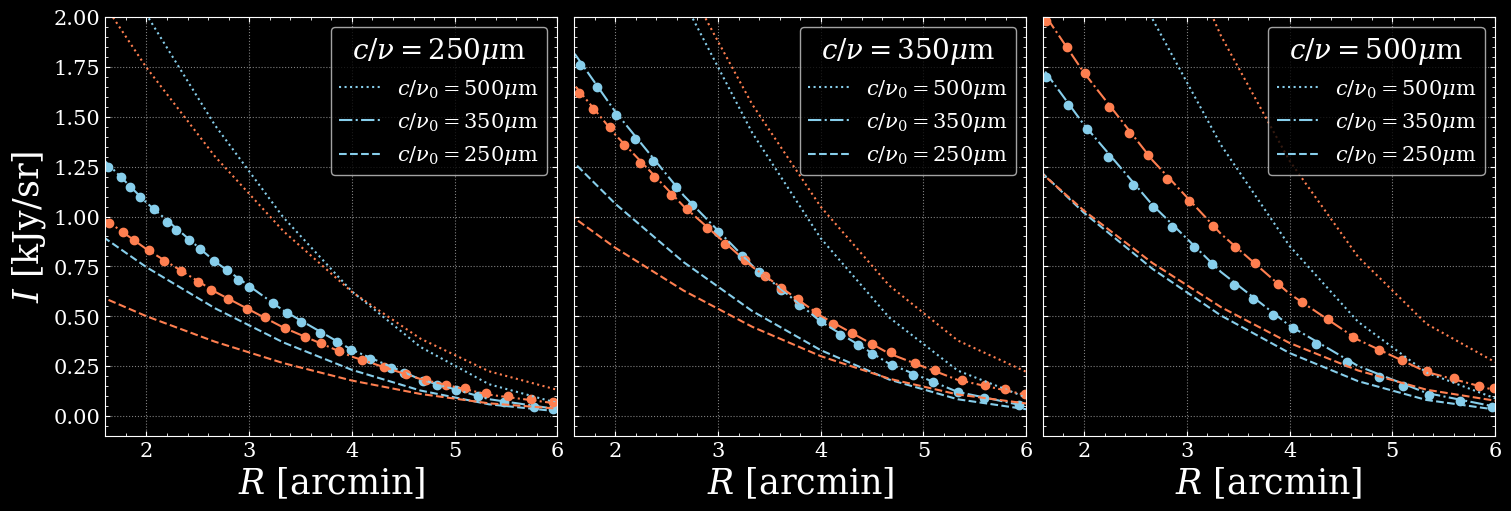

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained', sharey=True)

axs[0].plot(x500, y500, 'o', c='skyblue'); axs[0].plot(x500h, y500h, 'o',  c='coral')
axs[1].plot(x350, y350, 'o', c='skyblue'); axs[1].plot(x350h, y350h, 'o',  c='coral')
axs[2].plot(x250, y250, 'o', c='skyblue'); axs[2].plot(x250h, y250h, 'o',  c='coral')

for nu, ax in zip([600, 856, 1200], axs):
    ax.plot(thetas, AmodeodustAH.dustpoly(thetas, nu, nu0=600)(), label=r'$c/\nu_0=500 \mu$m', c='skyblue', ls=':')
    ax.plot(thetas, AmodeodustH.dustpoly(thetas, nu,nu0=600)(), c='coral', ls=':')
    ax.plot(thetas, AmodeodustAH.dustpoly(thetas, nu,nu0=856)(), label=r'$c/\nu_0=350 \mu$m', c='skyblue', ls='dashdot')
    ax.plot(thetas, AmodeodustH.dustpoly(thetas, nu,nu0=856)(), c='coral', ls='dashdot')
    ax.plot(thetas, AmodeodustAH.dustpoly(thetas, nu, nu0=1200)(), label=r'$c/\nu_0=250 \mu$m', c='skyblue', ls='--')
    ax.plot(thetas, AmodeodustH.dustpoly(thetas, nu, nu0=1200)(), c='coral', ls='--')


axs[0].set(xlabel=r'$R$ [arcmin]', ylabel=r'$I$ [kJy/sr]', xlim=(1.6, 6), ylim=(-0.1, 2)); axs[0].legend(title=r'$c/\nu=250 \mu$m')
axs[1].set(xlabel=r'$R$ [arcmin]', xlim=(1.6, 6)); axs[1].legend(title=r'$c/\nu=350 \mu$m')
axs[2].set(xlabel=r'$R$ [arcmin]', xlim=(1.6, 6)); axs[2].legend(title=r'$c/\nu=500 \mu$m')

plt.show()

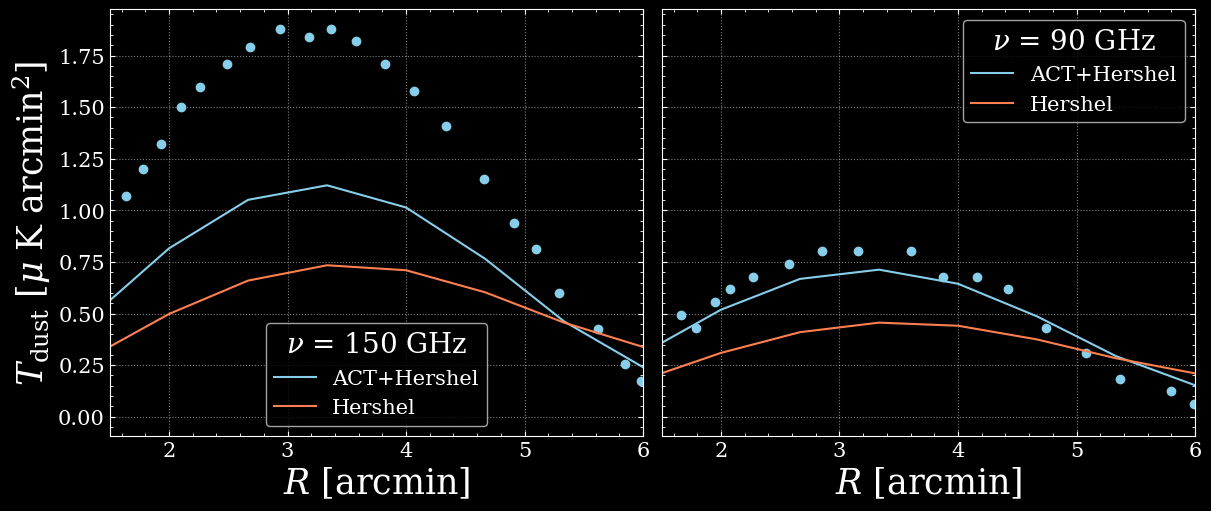

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='constrained', sharey=True)

axs[0].plot(roughdustx150, roughdusty150, 'o', c='skyblue')
axs[1].plot(roughdustx90, roughdusty90, 'o', c='skyblue')

axs[0].plot(thetas, AmodeodustAH.dust_uK(thetas, 150)(), label=r'ACT+Hershel', c='skyblue')
axs[0].plot(thetas, AmodeodustH.dust_uK(thetas, 150)(), label=r'Hershel', c='coral')

axs[1].plot(thetas, AmodeodustAH.dust_uK(thetas, 90)(), label=r'ACT+Hershel', c='skyblue')
axs[1].plot(thetas, AmodeodustH.dust_uK(thetas, 90)(), label=r'Hershel', c='coral')

axs[0].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{dust}$ [$\mu$ K arcmin$^2$]', xlim=(1.5, 6)); axs[0].legend(title=r'$\nu$ = 150 GHz')
axs[1].set(xlabel=r'$R$ [arcmin]', xlim=(1.5, 6)); axs[1].legend(title=r'$\nu$ = 90 GHz')

plt.show()

# More Measurements

In [ ]:
Liupath = '/global/homes/c/cpopik/Data/Liu2025'

# Spectroscopic distributions of four sub-sample photometric redshift bins, derived from 2.3 million DESI spectroscopic redshifts. The unit on the y axis are the number of galaxies per square degree within the redshift bin, with widthdz = 0.01.
zdist = np.genfromtxt(f"{Liupath}/fig2_main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt")

# ACT DR6 fiducial y-parameter stacked profiles alongside stacked profiles using deprojected CIB y-parameter maps with varying values of the β parameter.
CIBdp = pd.read_csv(f"{Liupath}/fig3.csv")
# ACT DR6 stacked profiles alongside the deprojected CIB profiles with varying values of β, for TCIB = 24.0K.
CIBdp_TCIB24 = pd.read_csv(f"{Liupath}/fig10.csv")

# ACT DR6 fiducial y-parameter stacked profiles alongside the profiles stacked on dβ moment-deprojected, CIBdeprojected y-parameter maps, with varying values of β
CIBdBetadp = pd.read_csv(f"{Liupath}/fig4.csv")
# CT DR6 stacked profiles alongside the deprojected CIB and dβ profiles, with varying values of β, for TCIB = 24.0K.
CIBdBetadp_TCIB24 = pd.read_csv(f"{Liupath}/fig11.csv")

# Non-Cumulative variant of Figure 3 showing the stacked profiles for the fiducial and CIB-deprojected y- parameter maps
CIBdp_noncum = pd.read_csv(f"{Liupath}/fig7.csv")
# Non-Cumulative variant of Figure 4 showing the stacked profiles for the fiducial and dβ moment-deprojected CIB-deprojected y-parameter maps.
CIBdBetadp_noncum = pd.read_csv(f"{Liupath}/fig8.csv")

# Plot of the ACT DR5 stacked profiles using the standard CAP filter as described by the window function in Equation 5. Note that the tSZ stacked profiles shown in the main body are all computed with the same filter.
DR5CAP = pd.read_csv(f"{Liupath}/fig12.csv")

# Plot of the ACT DR5 stacked profiles using the ring-ring filter. The filter masks out the central area of the stack following Equation A1, with θ0 = 1 arcmin.
DR5ringring = pd.read_csv(f"{Liupath}/fig13.csv")

In [113]:
DR5CAP

,Unnamed: 0,RApArcmin,pz1_act_dr5_f90,pz1_act_dr5_f90_err,pz1_act_dr5_f150,pz1_act_dr5_f150_err,pz2_act_dr5_f90,pz2_act_dr5_f90_err,pz2_act_dr5_f150,pz2_act_dr5_f150_err,pz3_act_dr5_f90,pz3_act_dr5_f90_err,pz3_act_dr5_f150,pz3_act_dr5_f150_err,pz4_act_dr5_f90,pz4_act_dr5_f90_err,pz4_act_dr5_f150,pz4_act_dr5_f150_err
0,0,1.0,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08,-1.245560e-07,1.940537e-08
1,1,1.5,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08,-6.492982e-08,3.551541e-08
2,2,2.0,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08,1.325903e-07,5.424730e-08
3,3,2.5,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08,2.476201e-07,8.310753e-08
4,4,3.0,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07,4.571910e-07,1.254914e-07
5,5,3.5,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07,6.197045e-07,1.933289e-07
6,6,4.0,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07,7.197468e-07,2.797989e-07
7,7,4.5,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07,7.503334e-07,3.909008e-07
8,8,5.0,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07,8.898094e-07,5.303058e-07
9,9,5.5,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07,9.723612e-07,6.990435e-07


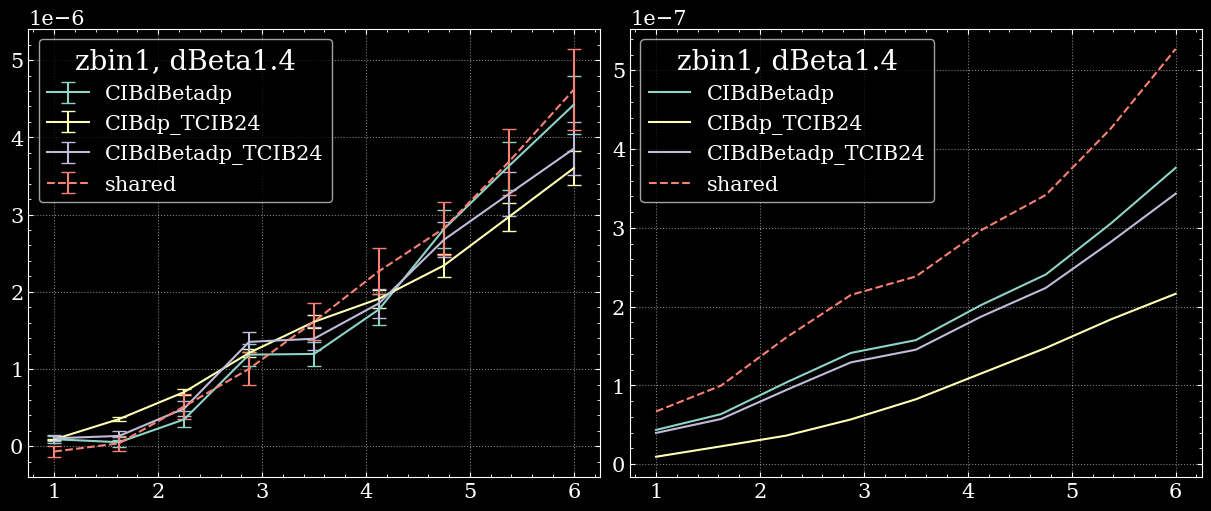

In [109]:
datapath = "/global/homes/c/cpopik/Data/"
zbin, dBeta = '1', '1.4'

fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='constrained')

dBetastr = f"dBeta_{dBeta}_10.7" if dBeta!='fiducial' else 'fiducial'
tSZdatafile = f"{datapath}/Liu2025_shared/DESI_pz{zbin}_act_dr6_{dBetastr}/diskring_tsz_uniformweight_measured.txt"
thetas = np.genfromtxt(tSZdatafile).T[0]  # [arcmin]
tSZdata, tSZerr = np.genfromtxt(tSZdatafile).T[1:3]*u.sr.to(u.arcmin**2)  # [ster]->[arcmin^2]

colstr = f"pz{zbin}_act_dr6_{dBetastr[1:-5] if dBeta!='fiducial' else 'fiducial'}"
axs[0].errorbar(CIBdBetadp['RApArcmin'], CIBdBetadp[colstr], yerr=CIBdBetadp[colstr+'_err'], capsize=5, label='CIBdBetadp')
axs[0].errorbar(CIBdp_TCIB24['RApArcmin'], CIBdp_TCIB24[colstr], yerr=CIBdp_TCIB24[colstr+'_err'], capsize=5, label='CIBdp_TCIB24')
axs[0].errorbar(CIBdBetadp_TCIB24['RApArcmin'], CIBdBetadp_TCIB24[colstr], yerr=CIBdBetadp_TCIB24[colstr+'_err'], capsize=5, label='CIBdBetadp_TCIB24')

axs[0].errorbar(thetas, tSZdata, yerr=tSZerr, capsize=5, ls='--', label='shared')

tSZcovfile = f"{datapath}/Liu2025_shared/DESI_pz{zbin}_act_dr6_{dBetastr}/cov_diskring_tsz_uniformweight_bootstrap.txt"
tSZcov = np.genfromtxt(tSZcovfile).T*u.sr.to(u.arcmin**2)**2  # [ster]->[arcmin^2]
axs[1].plot(CIBdBetadp['RApArcmin'], CIBdBetadp[colstr+'_err'], label='CIBdBetadp')
axs[1].plot(CIBdp_TCIB24['RApArcmin'], CIBdp_TCIB24[colstr+'_err'], label='CIBdp_TCIB24')
axs[1].plot(CIBdBetadp_TCIB24['RApArcmin'], CIBdBetadp_TCIB24[colstr+'_err'], label='CIBdBetadp_TCIB24')
axs[1].plot(thetas, np.diag(tSZcov)**0.5, ls='--', label='shared')

axs[0].legend(title=f"zbin{zbin}, dBeta{dBeta}"), axs[1].legend(title=f"zbin{zbin}, dBeta{dBeta}")

plt.show()

In [488]:
Riedpath = '/global/homes/c/cpopik/Data/RiedGuachalla2025'

# Redshift distribution of the DESI LRG Y1 galaxies overlapping the ACT map (∼ 39% of the total LRG sample).
zdist = dict(np.load(f"{Riedpath}/fig2_hist_z.npz"))
# The binned stellar mass distribution of the DESI LRG Y1 galaxies overlapping the ACT DR6 map
mdist = dict(np.load(f"{Riedpath}/fig3_mass_dist.npz"))
# The measured stacked kSZ in μK arcmin2 for varying CAP filters with radius R from Eq. 8 in brown.
stacked_ksz = dict(np.load(f"{Riedpath}/fig8_fiducial.npz"))
# Mean stacked kSZ profiles for the different redshift bins.
stacked_ksz_zbins = dict(np.load(f"{Riedpath}/fig11_ksz_z.npz"))
# Similar to Fig. 11, the kSZ stacked profiles for the different stellar mass bins, denoted by mass.
stacked_ksz_mbins = dict(np.load(f"{Riedpath}/fig12_ksz_mass.npz"))
# Comparison between the kSZ stacked CAP profiles obtained when using the different galaxy samples from DESI Y1: BGS (in purple) and ELG (in blue), both compared to the LRG main result.
stacked_ksz_othersamples = dict(np.load(f"{Riedpath}/fig14_other_samples.npz"))
# Comparison between the kSZ stacked CAP profiles obtained when using the photometric DESI LRG sample (from the DESI Legacy Imaging Surveys DR9 in red, subsample from what is used in [42]) and its spectroscopic counterpart (from DESI Y1 in brown).
stacked_ksz_ls_dr9 = dict(np.load(f"{Riedpath}/fig15_ls_dr9.npz"))
# The redshift distribution of the DESI LRG Y1 is shown for both the North Galactic Cap (NGC) and South Galactic Cap (SGC), along with the BOSS data.
zdist_boss = dict(np.load(f"{Riedpath}/fig20_hist_z.npz"))
# both the DESI Y1 and CMASS LRG on the ACT DR6 map, for which we find great agreement.
zdist_boss = dict(np.load(f"{Riedpath}/fig21_cmass.npz"))


# Beams

In [654]:
datapath = "/global/homes/c/cpopik/Data/"

ells_b, dr5beam_data150 = np.genfromtxt(f"{datapath}/ACTDR5/beams/act_planck_dr5.01_s08s18_f150_daynight_beam.txt").T
dr5beam_ells90, dr5beam_data90 = np.genfromtxt(f"{datapath}/ACTDR5/beams/act_planck_dr5.01_s08s18_f090_daynight_beam.txt").T

dr5resp150 = np.genfromtxt(f"{datapath}/ACTDR5/responses/act_planck_dr5.01_s08s18_AA_f150_daynight_response_tsz.txt").T
ells_r = dr5resp150[0]

dr5resp90 = np.genfromtxt(f"{datapath}/ACTDR5/responses/act_planck_dr5.01_s08s18_AA_f090_daynight_response_tsz.txt").T

bpath ="/global/cfs/projectdirs/act/data/act_dr6v4/beams/daytime_beams/"
daytime150=  np.genfromtxt(bpath+"/beam_full_pa6_f150_daywide_beam.txt").T
daytime90=  np.genfromtxt(bpath+"/beam_full_pa6_f090_daywide_beam.txt").T

FWHM = 1.6 * u.arcmin.to(u.rad)
sigma = FWHM/np.sqrt(8*np.log(2))
gaussbeam = np.exp(-ells_b*(ells_b+1)*sigma**2/2)

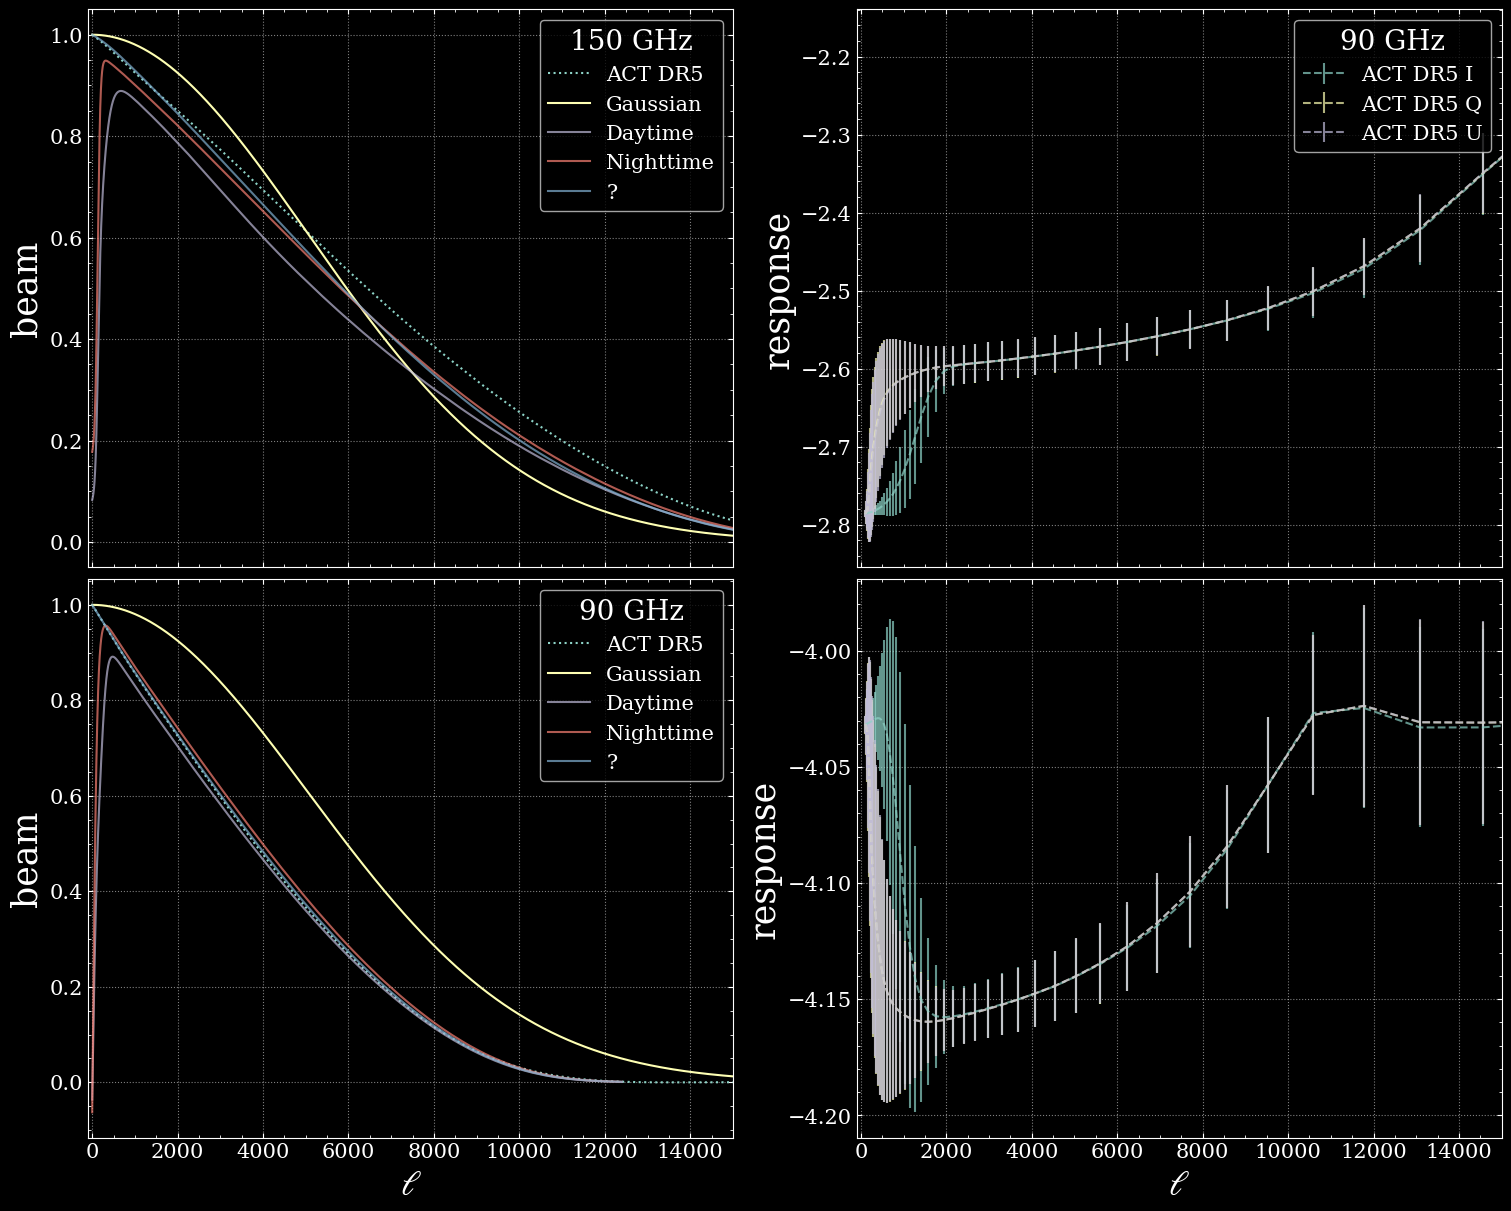

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), layout='constrained', sharex=True)
axs = axs.flatten()

axs[0].plot(ells_b, dr5beam_data150, label='ACT DR5', ls=':')
axs[2].plot(ells_b, dr5beam_data90, label='ACT DR5', ls=':')
axs[0].plot(ells_b, gaussbeam, label='Gaussian')
axs[2].plot(ells_b, gaussbeam, label='Gaussian')

axs[0].plot(daytime150[0], daytime150[1], alpha=0.7, label=f'Daytime')
axs[0].plot(daytime150[0], daytime150[3], alpha=0.7, label=f'Nighttime')
axs[0].plot(daytime150[0], daytime150[5], alpha=0.7, label=f'?')

axs[2].plot(daytime90[0], daytime90[1], alpha=0.7, label=f'Daytime')
axs[2].plot(daytime90[0], daytime90[3], alpha=0.7, label=f'Nighttime')
axs[2].plot(daytime90[0], daytime90[5], alpha=0.7, label=f'?')

axs[1].errorbar(ells_r, dr5resp150[1], dr5resp150[2], alpha=0.7, ls='--', label='ACT DR5 I')
axs[1].errorbar(ells_r, dr5resp150[3], dr5resp150[4], alpha=0.7, ls='--', label='ACT DR5 Q')
axs[1].errorbar(ells_r, dr5resp150[5], dr5resp150[6], alpha=0.7, ls='--', label='ACT DR5 U')
axs[3].errorbar(ells_r, dr5resp90[1], dr5resp90[2], alpha=0.7, ls='--', label='ACT DR5 I')
axs[3].errorbar(ells_r, dr5resp90[3], dr5resp90[4], alpha=0.7, ls='--', label='ACT DR5 Q')
axs[3].errorbar(ells_r, dr5resp90[5], dr5resp90[6], alpha=0.7, ls='--', label='ACT DR5 U')

axs[0].set(ylabel=r'beam'), axs[0].legend(title=r'150 GHz')
axs[2].set(xlabel=(r'$\ell$'), ylabel=r'beam', xlim=(-100, 15000)), axs[2].legend(title=r'90 GHz')

axs[1].set(ylabel=r'response'), axs[1].legend(title=r'150 GHz')
axs[3].set(xlabel=(r'$\ell$'), ylabel=r'response'), axs[1].legend(title=r'90 GHz')

plt.show()

In [576]:
ViewDataOrganization("/global/cfs/projectdirs/act/data/act_dr6v4/beams")

ACT DR6.02 beams

*** Main beams ***

Harmonic beam profiles for the DR6.02 nighttime maps and selected nighttime null test maps.

The files are formatted as follows:

{split_type}_{array}_{freq}_night_beam_tform_{beam_type}.txt

"split_type" is either "coadd" or "set{0..3}". The sets refer to the four independent
noise splits of the dr6.02 maps. The "coadd" split_type is a weighted average of the
per-split beams. The "coadd" beam is used for the power spectrum likelihood. The "coadd" beam
should be sufficient for most analyses, the per-split beams deviate by less than 1% from the
coaddded beam for multipoles < 10_000.

"beam_type" refers to either "instant", "jitter_cmb" or "jitter_mono". The "jitter_cmb" type
is the beam estimate after the CMB color-correction and the jitter correction have been applied.
This beam is most appropriate for the CMB signal in the DR6.02 maps. The "instant" beam
is the instantenous beam, i.e. the beam estimate before the CMB color-correction and jitter
co

In [633]:
ViewDataOrganization("/global/cfs/projectdirs/act/data/act_dr6v4/beams/daytime_beams")

No README file


/global/cfs/projectdirs/act/data/act_dr6v4/beams/daytime_beams/
     beam_full_pa4_f220_daydeep_modes.txt6 MB
     beam_full_pa6_f090_daywide_modes.txt3 MB
     beam_full_pa5_f090_daydeep_beam.txt1 MB
     beam_full_pa4_f150_daywide_beam.txt1 MB
     beam_full_pa5_f150_daydeep_beam.txt1 MB
     beam_full_pa6_f090_daywide_beam.txt1 MB
     beam_full_pa6_f090_daydeep_modes.txt3 MB
     beam_full_pa5_f090_daywide_modes.txt3 MB
     beam_full_pa6_f150_daywide_modes.txt4 MB
     beam_full_pa6_f150_daywide_beam.txt1 MB
     beam_full_pa5_f150_daywide_beam.txt1 MB
     beam_full_pa4_f150_daydeep_beam.txt1 MB
     beam_full_pa4_f150_daywide_modes.txt4 MB
     beam_full_pa6_f090_daydeep_beam.txt1 MB
     beam_full_pa6_f150_daydeep_beam.txt1 MB
     beam_full_pa4_f220_daywide_beam.txt2 MB
     beam_full_pa4_f220_daydeep_beam.txt2 MB
     beam_full_pa4_f150_daydeep_modes.txt4 MB
     beam_full_pa5_f090_daydeep_modes.txt3 MB
     beam_full_pa4_f220_daywide_modes.txt6 MB
     beam_

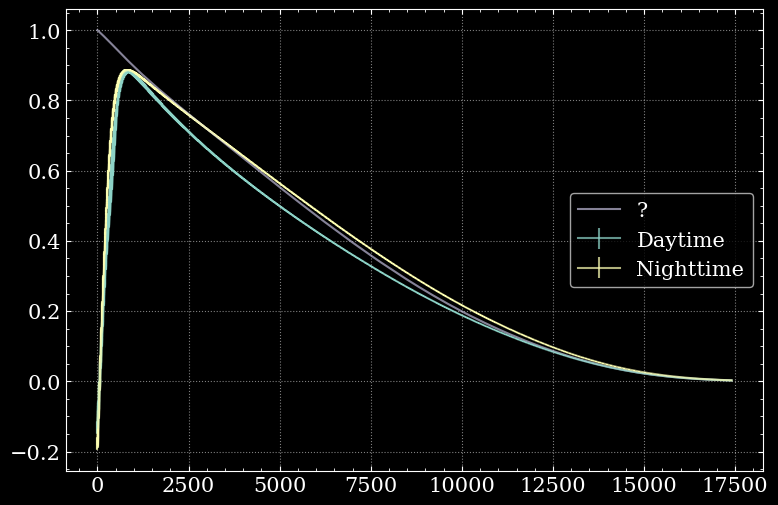

In [621]:
bpath ="/global/cfs/projectdirs/act/data/act_dr6v4/beams/daytime_beams/"
thing=  np.genfromtxt(bpath+"/beam_full_pa4_f150_daywide_beam.txt").T

plt.errorbar(thing[0], thing[1], yerr=thing[2], alpha=0.7, label=f'Daytime')
plt.errorbar(thing[0], thing[3], yerr=thing[4], alpha=0.7, label=f'Nighttime')
plt.plot(thing[0], thing[5], alpha=0.7, label=f'?')


plt.legend(loc='right')

In [ ]:
bpath ="/global/cfs/projectdirs/act/data/act_dr6v4/passbands/processed"
thing = np.load(bpath+"/passband_dr6_pa4_f150.dat").T

# Emily/Stefania mdist

In [ ]:
mfile = "/global/homes/c/cpopik/Capybara/Data/mass_distrib.txt"
logmraws = np.log10(np.genfromtxt(mfile))
mbins = np.arange((np.floor(logmraws.min()*10)/10).round(1), (np.ceil(logmraws.max()*10)/10+0.1).round(1), 0.1)
SMF, mstars = np.histogram(logmraws, bins=mbins)
SMF = SMF[None, :]
zs = np.array([0.55])

In [ ]:
# class Zhou2022:  # DESI LRGs (arxiv.org/abs/2208.08515)
#     path = "/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/"


# class Amodeo2021():
#     mfile = "/global/homes/c/cpopik/Capybara/Data/mass_distrib.txt"
#     def __init__(self):
#         self.logmraws = np.log10(np.genfromtxt(self.mfile))
#         mbins = np.arange((np.floor(self.logmraws.min()*10)/10).round(1), (np.ceil(self.logmraws.max()*10)/10+0.1).round(1), 0.1)
#         self.SMF, self.mstars = np.histogram(self.logmraws, bins=mbins)
#         self.SMF = self.SMF[None, :]
#         self.zs = np.array([0.55])


# class Amodeo2021():
#     # These are how the centers are determind in mop-c-gt and SOLikeT_szlike, then uses Kravstov2014 Mvir_scatter
#     logmstarbins = np.linspace(9.42, 11.73, 10)
#     logmstar = (logmstarbins[1:]+logmstarbins[:-1])/2
    
#     def __init__(self):
#         pass

# Combining zdist from DESI Cross-Corr LRGs with SMF from DESI 1%

In [ ]:
    def reweight_on_dist(self, z1, z1bins, N1, z2, z2bins, N2):  # If you want to reweight N1 by some array N2
        # Determine which array is the finer one
        if z1[1]-z1[0]<=z2[1]-z2[0]:  zf, zfbins, Nf, zc, zcbins, Nc = z1, z1bins, N1, z2, z2bins, N2
        else: zf, zfbins, Nf, zc, zcbins, Nc = z2, z2bins, N2, z1, z1bins, N1

        # Bin the finer array by the coarse bins, where it falls into the bins
        binidxs = np.digitize(zf, zcbins)-1
        binvalid = (zf>=zcbins[0]) & (zf<=zcbins[-1])
        zcbinvalid = (zc>=zfbins[0]) & (zc<=zfbins[-1])

        # Recreate the finer disutribution following the coarse bins
        Nfc = np.bincount(binidxs[binvalid], weights=Nf[binvalid], minlength=zc.size)

        # Return scaling factor for the requested distribution
        if N1 is Nc: 
            return np.where(Nc==0, 0, Nfc/Nc) * np.sum(Nc[zcbinvalid])/np.sum(Nfc)
        elif N1 is Nf: 
            noinf = np.zeros(Nf.shape)
            noinf[binvalid] = np.where(Nfc[binidxs[binvalid]]!=0, (Nc/Nfc)[binidxs[binvalid]], 0)
            return noinf * np.sum(Nf[binvalid])/np.sum(Nc)
            # return np.where(binvalid, np.where(Nfc[binidxs]!=0, (Nc/Nfc)[binidxs], 0), 0)

In [135]:
zdistfile="/global/homes/c/cpopik/Data/Zhou2023B/extended_lrg_pz_dndz_iron_v0.4_dz_0.02.txt"
pd.read_csv(zdistfile, sep=" ", usecols=range(1, 17))

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south
0,0.02,0.055,0.000,0.000,0.000,0.000,0.177,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.000
1,0.04,0.055,0.000,0.000,0.000,0.000,0.175,0.000,0.000,0.000,0.000,0.000,0.0,0.00,0.000,0.000
2,0.06,0.202,0.000,0.000,0.055,0.000,0.352,0.000,0.000,0.175,0.000,0.134,0.0,0.00,0.000,0.000
3,0.08,0.863,0.107,0.058,0.000,0.000,1.580,0.343,0.186,0.000,0.000,0.537,0.0,0.00,0.000,0.000
4,0.10,2.277,0.054,0.209,0.152,0.093,2.280,0.174,0.362,0.178,0.000,2.275,0.0,0.14,0.140,0.136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1.40,0.554,0.000,0.059,0.000,0.111,0.883,0.000,0.188,0.000,0.356,0.404,0.0,0.00,0.000,0.000
70,1.42,0.739,0.000,0.000,0.099,0.000,0.884,0.000,0.000,0.000,0.000,0.673,0.0,0.00,0.143,0.000
71,1.44,0.338,0.000,0.000,0.000,0.026,0.705,0.000,0.000,0.000,0.000,0.172,0.0,0.00,0.000,0.038
72,1.46,0.185,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.269,0.0,0.00,0.000,0.000


In [132]:
pd.read_csv(zdistfile, sep=" ", usecols=range(1, 17))

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south
0,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001
1,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002
2,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002
3,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004
4,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002
145,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
146,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
147,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [142]:
'Bruzual-Charlot' if pop=='bc03' else pop=='Maraston' 'm11'

NameError: name 'pop' is not defined

In [145]:
pd.read_csv("/global/homes/c/cpopik/Data/Zhou2023B/main_lrg_pz_dndz_decals_des_iron_v0.4_dz_0.02.txt", sep=" ", header=0)

,#,zmin,zmax,all_decals,bin_1_decals,bin_2_decals,bin_3_decals,bin_4_decals,all_des,bin_1_des,bin_2_des,bin_3_des,bin_4_des
0,0.00,0.02,0.018,0.003,0.001,0.003,0.003,0.008,0.000,0.000,0.003,0.002,NaN
1,0.02,0.04,0.070,0.008,0.006,0.006,0.005,0.052,0.000,0.003,0.006,0.014,NaN
2,0.04,0.06,0.154,0.014,0.013,0.007,0.009,0.203,0.017,0.017,0.006,0.014,NaN
3,0.06,0.08,0.231,0.023,0.021,0.014,0.008,0.221,0.021,0.017,0.009,0.003,NaN
4,0.08,0.10,0.294,0.033,0.026,0.021,0.019,0.289,0.021,0.023,0.021,0.015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1.38,1.40,0.086,0.001,0.003,0.004,0.010,0.064,0.000,0.000,0.003,0.005,NaN
70,1.40,1.42,0.066,0.001,0.002,0.002,0.007,0.038,0.000,0.000,0.000,0.000,NaN
71,1.42,1.44,0.042,0.000,0.001,0.003,0.006,0.067,0.006,0.003,0.000,0.012,NaN
72,1.44,1.46,0.019,0.001,0.000,0.001,0.002,0.021,0.000,0.000,0.003,0.000,NaN


In [144]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', *, sep: 'str | None | lib.NoDefault' = <no_default>, delimiter: 'str | None | lib.NoDefault' = None, header: "int | Sequence[int] | None | Literal['infer']" = 'infer', names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>, index_col: 'IndexLabel | Literal[False] | None' = None, usecols: 'list[HashableT] | Callable[[Hashable], bool] | None' = None, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters: 'Mapping[Hashable, Callable] | None' = None, true_values: 'list | None' = None, false_values: 'list | None' = None, skipinitialspace: 'bool' = False, skiprows: 'list[int] | int | Callable[[Hashable], bool] | None' = None, skipfooter: 'int' = 0, nrows: 'int | None' = None, na_values: 'Sequence[str] | Mapping[str, Sequence[str]] | None' = None, keep_default_na: 'bool' = True, na_filter: 'bool' = True, verbos

In [117]:
pd.read_csv(zdistfile, sep=" ").columns

Index(['#', 'zmin', 'zmax', 'all_combined', 'bin_1_combined', 'bin_2_combined',
       'bin_3_combined', 'bin_4_combined', 'all_north', 'bin_1_north',
       'bin_2_north', 'bin_3_north', 'bin_4_north', 'all_south', 'bin_1_south',
       'bin_2_south', 'bin_3_south', 'bin_4_south'],
      dtype='object')

In [ ]:
usecols=lambda c: c != '#'

In [ ]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']
import Models.SMFs as SMFs

In [3]:
desi1p = SMFs.DESI1Percent({'sample':'LRG'})
cmass = SMFs.BOSSDR10({'galaxy':'CMASS','group':'portsmouth', 'template':'passive', 'IMF':'Kroupa'})

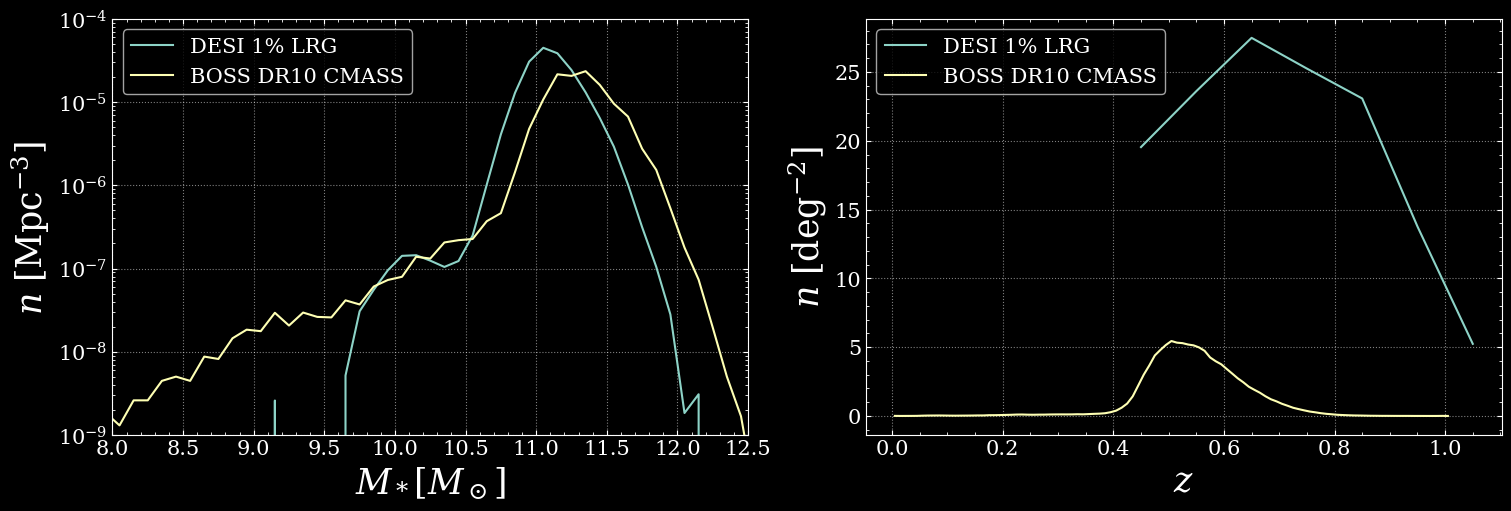

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
axs[0].set(xlabel=r'$M_* [M_\odot]$', ylabel=r'$n$ [Mpc$^{-3}$]', yscale='log', xlim=(8, 12.5), ylim=(1e-9, 1e-4))
axs[1].set(xlabel=r'$z$', ylabel=r'$n$ [deg$^{-2}$]')


axs[0].plot(desi1p.logmstar, np.average(desi1p.dndlogmstar(**cpars)*desi1p.dlogmstar, weights=desi1p.volumes(**cpars), axis=0), label='DESI 1% LRG')

axs[0].plot(cmass.logmstar, np.average(cmass.dndlogmstar(**cpars)*cmass.dlogmstar, weights=cmass.volumes(**cpars), axis=0), label='BOSS DR10 CMASS')

axs[1].plot(desi1p.z, np.trapz(desi1p.N(**cpars)/desi1p.dlogmstar, desi1p.logmstar)/desi1p.area, label='DESI 1% LRG')
axs[1].plot(cmass.z, np.trapz(cmass.N(**cpars)/cmass.dlogmstar, cmass.logmstar)/cmass.area, label='BOSS DR10 CMASS')

axs[0].legend(), axs[1].legend(); plt.show()

In [62]:
interp1 = scipy.interpolate.RegularGridInterpolator((desi1p.z, desi1p.logmstar), desi1p.dndlogmstar(**cpars))
interp2 = scipy.interpolate.RegularGridInterpolator((desi1p.z, desi1p.logmstar), desi1p.N(**cpars))



valid = (cmass.z<=desi1p.z[-1]) & (cmass.z>=desi1p.z[0])
Z, LOGM = np.meshgrid(cmass.z[valid], desi1p.logmstar, indexing='xy')

new_smf = interp1(np.stack([Z, LOGM], axis=-1)).T
new_N = interp2(np.stack([Z, LOGM], axis=-1)).T

new_smf2 = new_smf*((np.trapz(cmass.N(**cpars)/cmass.dlogmstar, cmass.logmstar))[valid]/(np.trapz(new_N/desi1p.dlogmstar, desi1p.logmstar)))[:, None]
new_N2 = new_N*((np.trapz(cmass.N(**cpars)/cmass.dlogmstar, cmass.logmstar))[valid]/(np.trapz(new_N/desi1p.dlogmstar, desi1p.logmstar)))[:, None]

In [63]:
interp1 = scipy.interpolate.RegularGridInterpolator((desi1p.z, desi1p.logmstar), desi1p.dndlogmstar(**cpars))
valid = (cmass.z<=desi1p.z[-1]) & (cmass.z>=desi1p.z[0])
Z, LOGM = np.meshgrid(cmass.z[valid], desi1p.logmstar, indexing='xy')
new_smf = interp1(np.stack([Z, LOGM], axis=-1)).T
new_N = new_smf*cmass.volumes(**cpars)[valid][:, None]*desi1p.dlogmstar
new_smf3 = new_smf*((np.trapz(cmass.N(**cpars)/cmass.dlogmstar, cmass.logmstar))[valid]/(np.trapz(new_N/desi1p.dlogmstar, desi1p.logmstar)))[:, None]
new_N3 = new_smf3*cmass.volumes(**cpars)[valid][:, None]*desi1p.dlogmstar

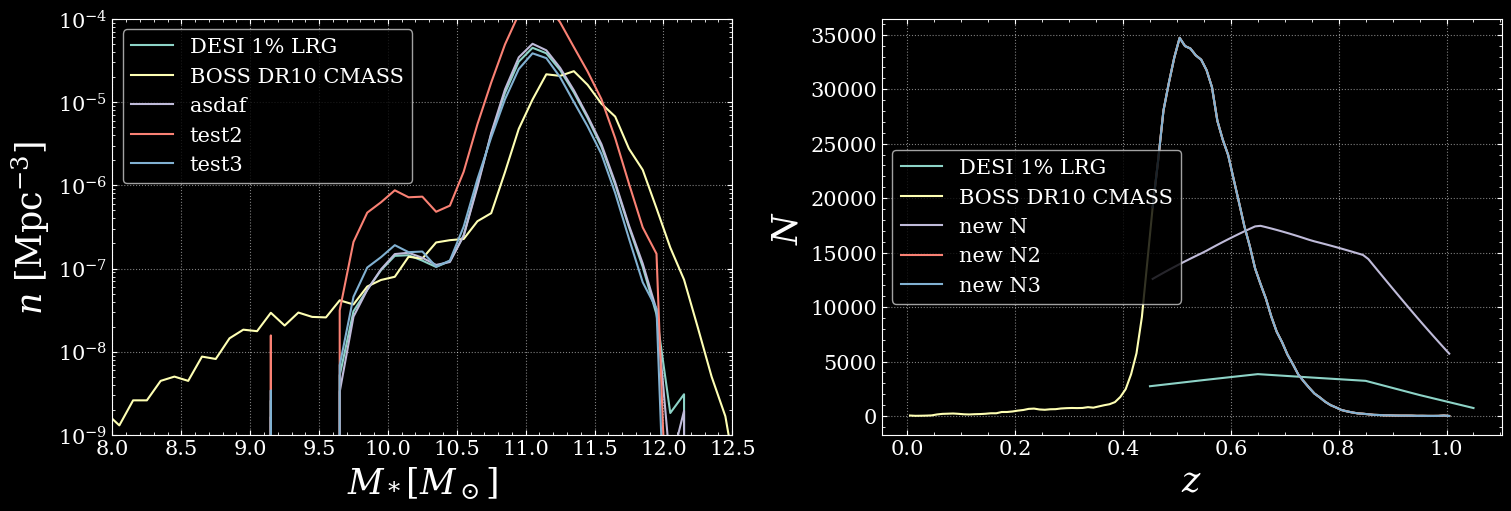

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
axs[0].set(xlabel=r'$M_* [M_\odot]$', ylabel=r'$n$ [Mpc$^{-3}$]', yscale='log', xlim=(8, 12.5), ylim=(1e-9, 1e-4))
axs[1].set(xlabel=r'$z$', ylabel=r'$N$')


axs[0].plot(desi1p.logmstar, np.average(desi1p.dndlogmstar(**cpars)*desi1p.dlogmstar, weights=desi1p.volumes(**cpars), axis=0), label='DESI 1% LRG')

axs[0].plot(cmass.logmstar, np.average(cmass.dndlogmstar(**cpars)*cmass.dlogmstar, weights=cmass.volumes(**cpars), axis=0), label='BOSS DR10 CMASS')

axs[1].plot(desi1p.z, np.trapz(desi1p.N(**cpars)/desi1p.dlogmstar, desi1p.logmstar), label='DESI 1% LRG')
axs[1].plot(cmass.z, np.trapz(cmass.N(**cpars)/cmass.dlogmstar, cmass.logmstar), label='BOSS DR10 CMASS')


axs[0].plot(desi1p.logmstar, np.average(new_smf*desi1p.dlogmstar, weights=cmass.volumes(**cpars)[valid], axis=0), label='asdaf')
axs[1].plot(cmass.z[valid], np.trapz(new_N/desi1p.dlogmstar, desi1p.logmstar), label='new N')


axs[0].plot(desi1p.logmstar, np.average(new_smf2*desi1p.dlogmstar, weights=cmass.volumes(**cpars)[valid], axis=0), label='test2')

axs[0].plot(desi1p.logmstar, np.average(new_smf3*desi1p.dlogmstar, weights=cmass.volumes(**cpars)[valid], axis=0), label='test3')

axs[1].plot(cmass.z[valid], np.trapz(new_N2/desi1p.dlogmstar, desi1p.logmstar), label='new N2')

axs[1].plot(cmass.z[valid], np.trapz(new_N3/desi1p.dlogmstar, desi1p.logmstar), label='new N3')


axs[0].legend(), axs[1].legend(); plt.show()

In [437]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']
import Models.SMFs as SMFs

In [438]:
desilrg.zdfdata

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south
0,0.00,0.02,0.016,0.002,0.002,0.002,0.002,0.014,0.000,0.003,0.002,0.001,0.017,0.002,0.001,0.003,0.003
1,0.02,0.04,0.065,0.007,0.006,0.006,0.008,0.057,0.006,0.006,0.008,0.012,0.068,0.007,0.005,0.006,0.006
2,0.04,0.06,0.141,0.012,0.013,0.007,0.010,0.102,0.007,0.013,0.008,0.012,0.159,0.014,0.014,0.007,0.009
3,0.06,0.08,0.220,0.021,0.026,0.014,0.009,0.199,0.016,0.040,0.014,0.011,0.229,0.023,0.020,0.013,0.008
4,0.08,0.10,0.277,0.026,0.030,0.019,0.018,0.245,0.014,0.040,0.016,0.017,0.291,0.032,0.026,0.020,0.019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1.38,1.40,0.077,0.001,0.002,0.003,0.009,0.063,0.000,0.002,0.003,0.009,0.083,0.001,0.002,0.004,0.009
70,1.40,1.42,0.064,0.001,0.001,0.003,0.006,0.066,0.002,0.000,0.006,0.006,0.063,0.001,0.002,0.001,0.006
71,1.42,1.44,0.042,0.001,0.001,0.002,0.005,0.034,0.000,0.000,0.000,0.003,0.045,0.001,0.001,0.002,0.006
72,1.44,1.46,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002


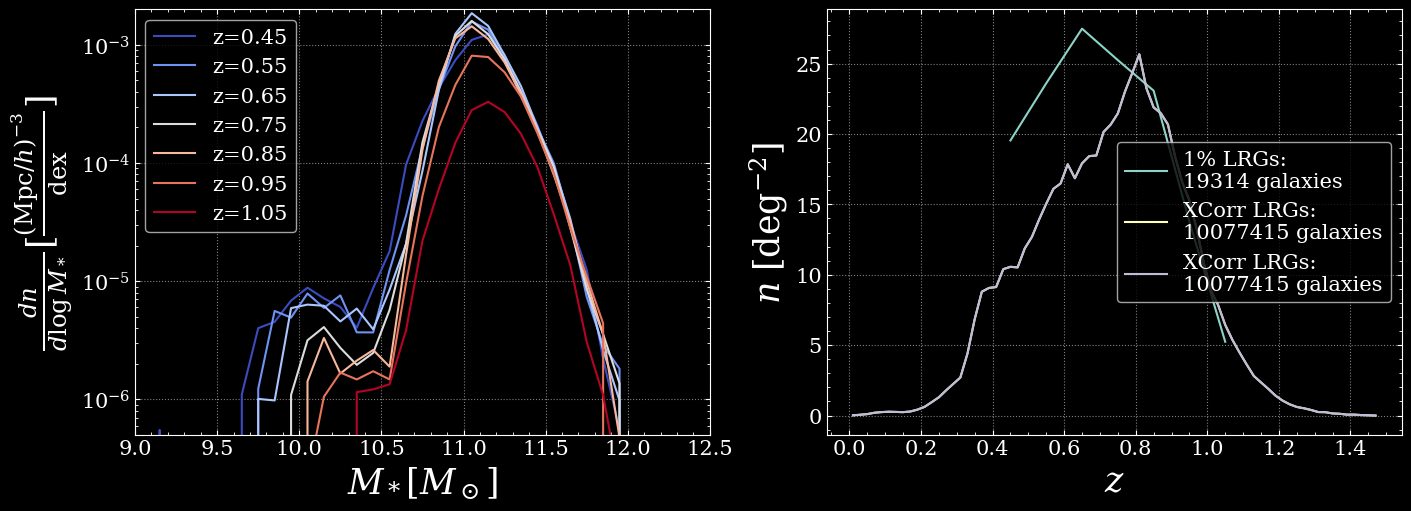

In [475]:
desi1p = SMFs.DESI1Percent({'sample':'LRG'})

desilrg = SMFs.DESILRGsCrossCorr({'pzbin':'2', 'hemisphere':'north','sample':'main'})
desilrg = SMFs.DESILRGsCrossCorr({'pzbin':'all', 'hemisphere':'north','sample':'main'})


fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
axs[0].set(ylabel=r'$\frac{dn}{d \log M_*} [\frac{(\text{Mpc}/h)^{-3}}{\text{dex}}$]', xlabel=r'$M_* [M_\odot]$', yscale='log', xlim=(9, 12.5), ylim=(5e-7, 2e-3))

for i in range(desi1p.z.size):
    axs[0].plot(desi1p.logmstar, desi1p.dndlogmstar_h3[i], label=f'z={desi1p.z[i]:.2f}', c=plt.get_cmap('coolwarm')((i/(desi1p.z.size-1))))
    
axs[1].set(ylabel=r'$n$ [deg$^{-2}$]', xlabel=r'$z$')
desi1p_N_z = np.sum(desi1p.N(**cpars), axis=1)
axs[1].plot(desi1p.z, desi1p_N_z/desi1p.area, label=f"1% LRGs: \n{np.sum(desi1p_N_z):.0f} galaxies")
axs[1].plot(desilrg.z, desilrg.N()/desilrg.area, label=f"XCorr LRGs: \n{np.sum(desilrg.N()):.0f} galaxies")

axs[1].plot(desilrg2.z, desilrg2.N()/desilrg2.area, label=f"XCorr LRGs: \n{np.sum(desilrg2.N()):.0f} galaxies")

axs[0].legend(); axs[1].legend(); plt.show()

In [476]:
def reweight_on_dist(z1, z1bins, N1, z2, z2bins, N2):  # If you want to reweight N1 by some array N2
    # Determine which array is the finer one
    if z1[1]-z1[0]<=z2[1]-z2[0]:  zf, zfbins, Nf, zc, zcbins, Nc = z1, z1bins, N1, z2, z2bins, N2
    else: zf, zfbins, Nf, zc, zcbins, Nc = z2, z2bins, N2, z1, z1bins, N1
    
    # Bin the finer array by the coarse bins, where it falls into the bins
    binidxs = np.digitize(zf, zcbins)-1
    binvalid = (zf>=zcbins[0]) & (zf<=zcbins[-1])
    zcbinvalid = (zc>=zfbins[0]) & (zc<=zfbins[-1])

    # Recreate the finer disutribution following the coarse bins
    Nfc = np.bincount(binidxs[binvalid], weights=Nf[binvalid], minlength=zc.size)

    # Return scaling factor for the requested distribution
    if N1 is Nc: 
        return np.where(Nc==0, 0, Nfc/Nc) * np.sum(Nc[zcbinvalid])/np.sum(Nfc)
    elif N1 is Nf: 
        noinf = np.zeros(Nf.shape)
        noinf[binvalid] = np.where(Nfc[binidxs[binvalid]]!=0, (Nc/Nfc)[binidxs[binvalid]], 0)
        return noinf * np.sum(Nf[binvalid])/np.sum(Nc)
        # return np.where(binvalid, np.where(Nfc[binidxs]!=0, (Nc/Nfc)[binidxs], 0), 0)

In [477]:
desi1p_xzdist = reweight_on_dist(desi1p.z, desi1p.zbins, desi1p_N_z, desilrg.z, desilrg.zbins, desilrg.N())
desix_1pzdist = reweight_on_dist(desilrg.z, desilrg.zbins, desilrg.N(), desi1p.z, desi1p.zbins, desi1p_N_z)

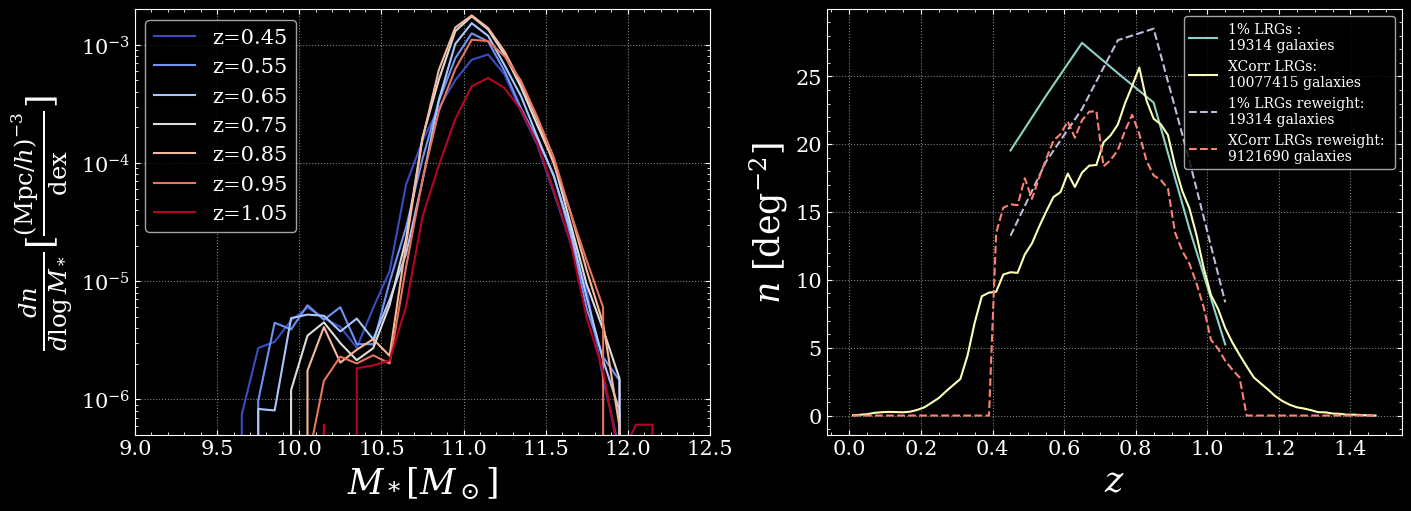

In [482]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
axs[0].set(ylabel=r'$\frac{dn}{d \log M_*} [\frac{(\text{Mpc}/h)^{-3}}{\text{dex}}$]', xlabel=r'$M_* [M_\odot]$', yscale='log', xlim=(9, 12.5), ylim=(5e-7, 2e-3))

for i in range(desi1p.z.size):
    axs[0].plot(desi1p.logmstar, desi1p_xzdist[i, None]*desi1p.dndlogmstar_h3[i], label=f'z={desi1p.z[i]:.2f}', c=plt.get_cmap('coolwarm')((i/(desi1p.z.size-1))))

axs[1].set(ylabel=r'$n$ [deg$^{-2}$]', xlabel=r'$z$')
desi1p_N_z = np.sum(desi1p.N(**cpars), axis=1)
axs[1].plot(desi1p.z, desi1p_N_z/desi1p.area, label=f"1% LRGs : \n{np.sum(desi1p_N_z):.0f} galaxies")

axs[1].plot(desilrg.z, desilrg.N_deg2, label=f"XCorr LRGs: \n{np.sum(desilrg.N()):.0f} galaxies")

axs[1].plot(desi1p.z, desi1p_xzdist*desi1p_N_z/desi1p.area, label=f"1% LRGs reweight: \n{np.sum(desi1p_xzdist*desi1p_N_z):.0f} galaxies", ls='--')

axs[1].plot(desilrg.z, desix_1pzdist*desilrg.N()/desilrg.area, label=f"XCorr LRGs reweight: \n{np.sum(desix_1pzdist*desilrg.N()):.0f} galaxies", ls='--')

axs[0].legend(); axs[1].legend(fontsize=10); plt.show()

In [163]:
np.sum(desi1p.N(**cpars))

18209.579885920575

In [ ]:
np.sum(desi1p.N(**cpars))

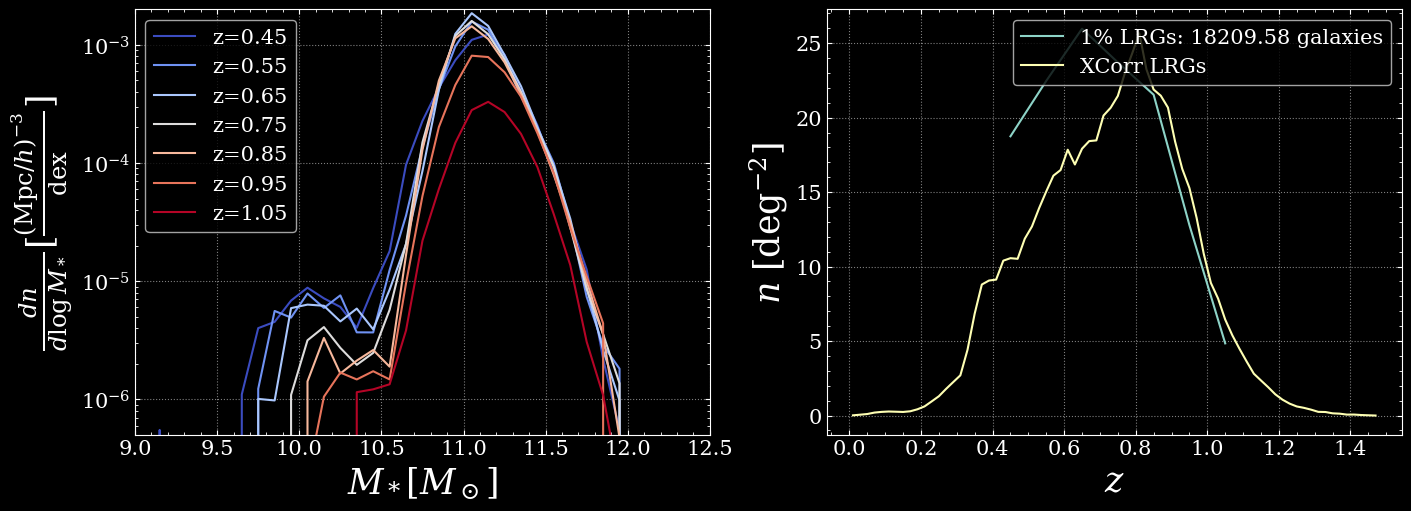

In [161]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')
axs[0].set(ylabel=r'$\frac{dn}{d \log M_*} [\frac{(\text{Mpc}/h)^{-3}}{\text{dex}}$]', xlabel=r'$M_* [M_\odot]$', yscale='log', xlim=(9, 12.5), ylim=(5e-7, 2e-3))

for i in range(desi1p.z.size):
    axs[0].plot(desi1p.logmstar, desi1p.dndlogmstar_h3[i], label=f'z={desi1p.z[i]:.2f}', c=plt.get_cmap('coolwarm')((i/(desi1p.z.size-1))))
    
axs[1].set(ylabel=r'$n$ [deg$^{-2}$]', xlabel=r'$z$')
desi1p_N_z = np.trapz(desi1p.N(**cpars)/desi1p.dlogmstar, desi1p.logmstar)
axs[1].plot(desi1p.z, desi1p_N_z/desi1p.area, label=f"1% LRGs: {np.sum(desi1p_N_z):.2f} galaxies")
axs[1].plot(desilrg.z, desilrg.N_deg2, label='XCorr LRGs')

axs[0].legend(); axs[1].legend(); plt.show()

In [129]:
desi1p.z is desilrg.z

False

In [28]:
desi1p = SMFs.DESI1Percent({'sample':'LRG'})

In [ ]:

    # def matchdist(self, olddistx,olddisty, newdistx,newdisty):
    #     dx = (self.olddistx[1]-self.olddistx[0])
    #     pd.cut(newdistx, bins=np.arange(self.olddistx[0]-dx/2, self.olddistx[:-1]+dx, dx))
        
    #     self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea
        
            

    
    
        # def gdist(self, **cosmopars):
    #     gdist = self.SMFraw*cosmopars["hh"]**3*self.SMF_to_N(**cosmopars)[:, None]
    #     if self.zweight=='True':
    #         self.LRGXcorrzdist()
    #         gdist = gdist*(self.zdistscale/np.sum(gdist, axis=1))[:, None]
    #     return gdist

    # def SMF(self, **cosmopars):
    #     SMF = self.SMFraw*cosmopars['hh']**3
    #     if self.zweight=='True':
    #         self.LRGXcorrzdist()
    #         SMF = SMF*(self.zdistscale/self.SMF_to_N(**cosmopars)/np.trapz(SMF, np.log10(self.mstars), axis=1))[:, None]
    #     return SMF
    
    # def LRGXcorrzdist(self):
    #     # Read in the redshift distribution for each specific bin
    #     # Number density in N / deg^2, dataframe with 1D arrays of length [ndim_zs_zdist]
    #     self.zdistdf = pd.read_csv(self.redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(self.redshift_dist_file, sep=" ").columns[1:])
    #     self.zdist = self.zdistdf[f"{self.zbin}_{self.hemisphere}"]

    #     # Sort/group/sum up the finer redshift bins to match the bins of the SMF distribution
    #     self.zdistdf['zbin'] = pd.cut(self.zdistdf['zmin'], bins=np.arange(self.zs[0], self.zs[-1]+0.2, 0.1))
    #     self.zdistscale = self.zdistdf.groupby('zbin')[f"{self.zbin}_{self.hemisphere}"].sum().values*self.surveyarea
    

    
    
    
    # redshift_dist_file = "/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist/main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt"  # arxiv.org/abs/2309.06443

In [2]:
ViewDataOrganization("/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist/")

The .txt files contain the redshift distributions of the Main and Extended samples in z spacing of 0.02 (and 0.01 spacing for the Main LRGs) as shown in Figures 2 and 3 in the paper.

In each file, the "all_*" columns correspond to the full sample without tomographic binning. The "*_combined" columns correspond to the weighted average of the North+South combined sample.

In main_lrg_pz_dndz_decals_des_iron_v0.4_dz_0.02.txt, the South sample is separated into DECaLS and DES, corresponding to Figure 12 in the paper.




/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist//
     README.txt
     main_lrg_pz_dndz_decals_des_iron_v0.4_dz_0.02.txt
     main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt
     extended_lrg_pz_dndz_iron_v0.4_dz_0.02.txt
     main_lrg_pz_dndz_iron_v0.4_dz_0.02.txt


In [8]:
sizeof_fmt(get_folder_size("/global/homes/c/cpopik/Capybara/Data"))

'138.3MB'

In [4]:
def get_folder_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            try:
                total_size += os.path.getsize(fp)
            except FileNotFoundError:
                pass  # In case the file is deleted between os.walk and os.path.getsize
    return total_size

# Example usage
folder_path = "/your/folder/path"
size_bytes = get_folder_size(folder_path)

# Convert to more readable format
def sizeof_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

print("Total size:", sizeof_fmt(size_bytes))

Total size: 0.0B


In [ ]:
redshift_dist_file="/global/cfs/projectdirs/desi/public/papers/c3/lrg_xcorr_2023/v1/redshift_dist/main_lrg_pz_dndz_iron_v0.4_dz_0.01.txt"
zbin, hemisphere='bin_1', 'combined'
zdistdf = pd.read_csv(redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(redshift_dist_file, sep=" ").columns[1:])
zdist = zdistdf[f"{zbin}_{hemisphere}"]

zs=np.linspace(0, 1, 10)
surveyarea=6000
# Sort/group/sum up the finer redshift bins to match the bins of the SMF distribution
zdistdf['zbin'] = pd.cut(zdistdf['zmin'], bins=np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1))
zdistscale = zdistdf.groupby('zbin', observed=False)[f"{zbin}_{hemisphere}"].sum().values*surveyarea

In [ ]:
filename = "/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/south/sweep-070m025-080m020-stellar-mass.fits.gz"
with fits.open(filename, memmap=True) as hdul:
    data = hdul[1].data  # Usually the table is in extension 1

# Convert to DataFrame
cols = ['STELLAR_MASS']  # replace with your actual column names
df = pd.DataFrame({col: hdul[1].data[col] for col in cols})

In [113]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']  # Clear the cache to avoid conflicts
import Models.SMFs as SMFs

In [118]:
cpars = {'hh': 0.7, 'Omega_L': 0.75, 'Omega_m': 0.25, 'Omega_b': 0.044, 'T_CMB': 2.726, 'XH':0.76, 'v_rms':1.06e-3}
SMFs.DESI1Percent({'sample':'LRG'}).N(**cpars)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.82004959e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.64009919e-01, 2.05221431e+00,
        2.31924768e+00, 3.51080332e+00, 4.51207935e+00, 3.66606447e+00,
        3.10205455e+00, 2.06706728e+00, 4.48304943e+00, 9.19537600e+00,
        4.96265251e+01, 1.16424113e+02, 2.22238981e+02, 3.80380671e+02,
        5.65595510e+02, 6.26996415e+02, 4.24059848e+02, 2.07661059e+02,
        1.07113903e+02, 4.22788295e+01, 1.61800073e+01, 6.42308215e+00,
        1.12801984e+00, 2.82004959e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [219]:
desi.z

array([0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])

In [229]:
finezs[21:28].values

array([0.215, 0.225, 0.235, 0.245, 0.255, 0.265, 0.275])

In [ ]:
finezs = (zdistdf.zmax+zdistdf.zmin)/2
fineN = zdistdf.all_combined.values
coarsezs = desi.z
coarseN = np.sum(desi.N(**cpars), axis=1)
binidxs, binvalid = np.digitize(finezs, coarsezs)-1, (finezs>=coarsezs[0]) & (finezs<=coarsezs[-1])
fineNcoarse = np.bincount(binidxs[binvalid], weights=fineN[binvalid], minlength=coarsezs.size)

Nc_scale = np.where(np.isinf(fineNcoarse/coarseN), 0, fineNcoarse/coarseN)
Nf_scale = np.where(np.isinf((coarseN/fineNcoarse)[binidxs]), 0, (coarseN/fineNcoarse)[binidxs])

/tmp/ipykernel_221256/1566169454.py:9: RuntimeWarning: divide by zero encountered in divide
  Nf_scale = np.where(np.isinf((coarseN/fineNcoarse)[binidxs]), 0, (coarseN/fineNcoarse)[binidxs])


In [326]:
np.sum(fineN*Nf_scale), np.sum(coarseN)

(19224.589310056574, 19993.773052095316)

In [328]:
np.sum(coarseN*Nc_scale), np.sum(fineN)

(504.71600000000007, 600.691)

In [335]:
fineN[binvalid]

array([ 5.584,  5.448,  5.715,  5.896,  6.158,  6.421,  6.361,  6.822,
        7.109,  7.253,  7.565,  7.895,  7.872,  7.939,  8.173,  8.53 ,
        8.72 ,  8.582,  8.681,  8.802,  9.052,  9.158,  9.086,  9.325,
        9.506,  9.536,  9.553,  9.776, 10.036, 10.455, 10.67 , 10.973,
       11.408, 11.653, 12.265, 12.431, 12.133, 11.809, 11.664, 11.488,
       11.123, 10.822, 10.627, 10.409,  9.847,  9.598,  8.969,  8.475,
        8.239,  7.842,  7.397,  6.804,  6.185,  5.611,  5.132,  4.687,
        4.452,  4.037,  3.59 ,  3.367])

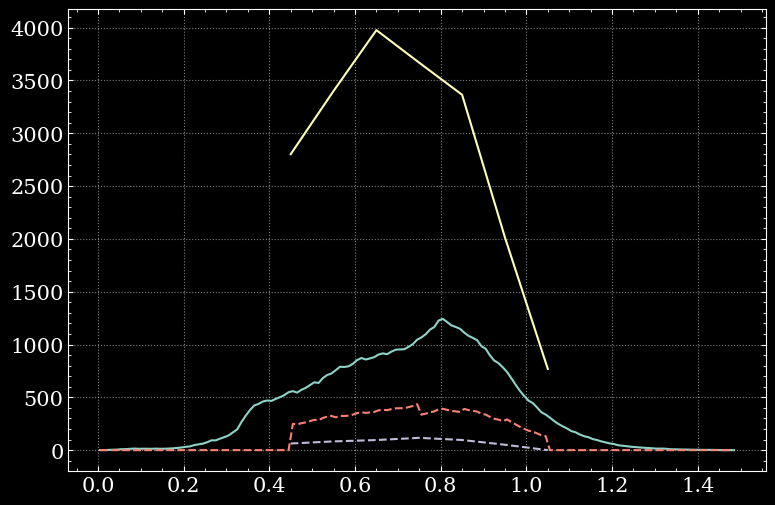

In [324]:
plt.plot(finezs, fineN*100)
plt.plot(coarsezs, coarseN)
plt.plot(coarsezs, np.sum(desi.N(**cpars), axis=1)*Nc_scale, ls='--')
plt.plot(finezs, fineN*Nf_scale, ls='--')

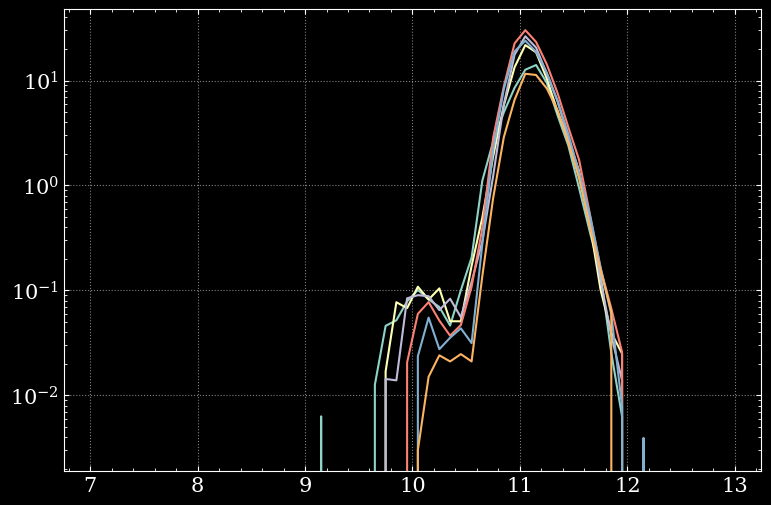

In [265]:
for i in range(coarseNnew.shape[0]):
    plt.plot(desi.logmstar, coarseNnew[i])
plt.yscale('log')

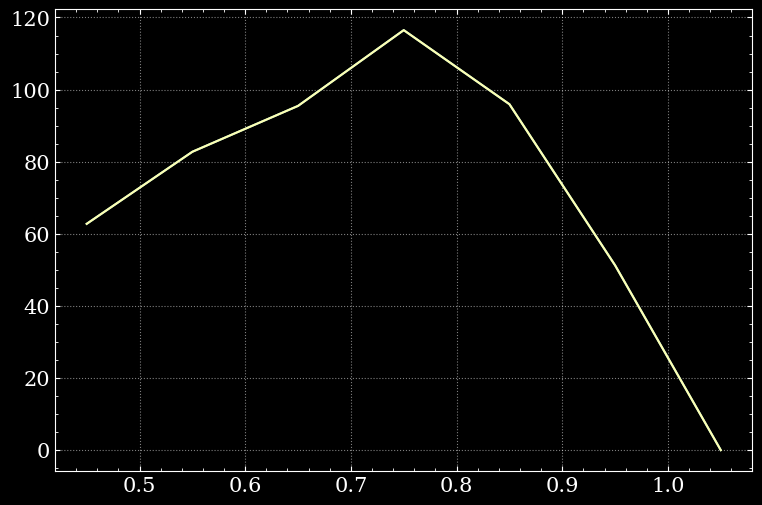

In [180]:
plt.plot(desi.z, newN)
plt.plot(desi.z, np.sum(newNdesi, axis=1))

In [97]:
zs = np.linspace(0, 1, 5)

In [87]:
oldzs

0      0.005
1      0.015
2      0.025
3      0.035
4      0.045
       ...  
144    1.445
145    1.455
146    1.465
147    1.475
148    1.485
Length: 149, dtype: float64

In [68]:
np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1)

array([0.005, 0.105, 0.205, 0.305, 0.405, 0.505, 0.605, 0.705, 0.805,
       0.905, 1.005, 1.105])

In [66]:
pd.cut(zdistdf['zmin'], bins=np.arange(kroupass.z[0], kroupass.z[-1]+0.2, 0.1))

0                 NaN
1      (0.005, 0.105]
2      (0.005, 0.105]
3      (0.005, 0.105]
4      (0.005, 0.105]
            ...      
144               NaN
145               NaN
146               NaN
147               NaN
148               NaN
Name: zmin, Length: 149, dtype: category
Categories (11, interval[float64, right]): [(0.005, 0.105] < (0.105, 0.205] < (0.205, 0.305] < (0.305, 0.405] ... (0.705, 0.805] < (0.805, 0.905] < (0.905, 1.005] < (1.005, 1.105]]

In [63]:
zdistdf.zmax.values[-1:]

array([1.49])

In [64]:
zbins = np.concatenate([zdistdf.zmin.values, zdistdf.zmax.values[-1:]])
N_deg2 = zdistdf[f"{zbin}_{hemisphere}"]

In [ ]:

N_deg2

0      0.001
1      0.001
2      0.002
3      0.005
4      0.005
       ...  
144    0.000
145    0.000
146    0.000
147    0.000
148    0.000
Name: bin_1_combined, Length: 149, dtype: float64

In [39]:
len(os.listdir("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/north"))+len(os.listdir("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/south"))

740

In [36]:
ViewDataOrganization("/global/cfs/projectdirs/desi/public/ets/vac/stellar_mass/v1/")

### arXiv:2208.08515                  DESI LRG target selection    (Zhou+, 2022)
Target Selection and Validation of DESI Luminous Red Galaxies
    Rongpu Zhou, Biprateep Dey, Jeffrey A. Newman, D. J. Eisenstein, K. Dawson,
    S. Bailey, A. Berti, J. Guy, Ting-Wen Lan, H. Zou, J. Aguilar, S. Ahlen,
    Shadab Alam, D. Brooks, A. de la Macorra, A. Dey, G. Dhungana, K. Fanning,
    A. Font-Ribera, S. Gontcho A Gontcho, K. Honscheid, Mustapha Ishak,
    T. Kisner, A. Kovacs, A. Kremin, M. Landriau, Michael E. Levi,
    C. Magneville, Marc Manera, P. Martini, Aaron M. Meisner, R. Miquel,
    J. Moustakas, Adam D. Myers, Jundan Nie, N. Palanque-Delabrouille,
    W.J. Percival, C. Poppett, F. Prada, A. Raichoor, A. J. Ross, E. Schlafly,
    D. Schlegel, M. Schubnell, Gregory Tarle, B. A. Weaver, R. H. Wechsler,
    Christophe Yèche, Zhimin Zhou

This directory contains the stellar mass catalogs. These catalogs are row-by-row
matched to the sweep catalogs in Legacy Surveys DR9 (https://www.le

In [30]:
zdistdf = pd.read_csv(redshift_dist_file, sep=" ", skiprows=1, names=pd.read_csv(redshift_dist_file, sep=" ").columns[1:])
zdistdf

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south
0,0.00,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001
1,0.01,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002
2,0.02,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002
3,0.03,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004
4,0.04,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.44,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002
145,1.45,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
146,1.46,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
147,1.47,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
def volumes(self, zs, hh, T_CMB, Omega_m, Omega_L, Omega_b, **kwargs):
    cosmo = astropy.cosmology.LambdaCDM(H0=hh*100, Tcmb0=T_CMB, Om0=Omega_m, Ode0=Omega_L, Ob0=Omega_b)

    vols = np.array([(cosmo.comoving_volume(z+self.dz/2).value-cosmo.comoving_volume(z-self.dz/2).value)/(1+z)**3 for z in self.z])

    return vols * (self.area/(4*np.pi*(180/np.pi)**2))

In [26]:
zdistdf.bin_1_combined

0      0.001
1      0.001
2      0.002
3      0.005
4      0.005
       ...  
144    0.000
145    0.000
146    0.000
147    0.000
148    0.000
Name: bin_1_combined, Length: 149, dtype: float64

In [ ]:
zdistdf.groupby('zbin')

AttributeError: 'DataFrame' object has no attribute 'group_by'

In [22]:
zdistdf

,zmin,zmax,all_combined,bin_1_combined,bin_2_combined,bin_3_combined,bin_4_combined,all_north,bin_1_north,bin_2_north,bin_3_north,bin_4_north,all_south,bin_1_south,bin_2_south,bin_3_south,bin_4_south,zbin
0,0.00,0.01,0.008,0.001,0.001,0.001,0.001,0.009,0.000,0.002,0.002,0.001,0.007,0.001,0.001,0.001,0.001,NaN
1,0.01,0.02,0.008,0.001,0.001,0.001,0.001,0.005,0.000,0.002,0.000,0.000,0.010,0.001,0.000,0.002,0.002,"(0.005, 0.105]"
2,0.02,0.03,0.023,0.002,0.001,0.002,0.004,0.018,0.000,0.000,0.002,0.007,0.025,0.003,0.002,0.002,0.002,"(0.005, 0.105]"
3,0.03,0.04,0.042,0.005,0.005,0.004,0.004,0.039,0.006,0.006,0.006,0.005,0.043,0.004,0.004,0.003,0.004,"(0.005, 0.105]"
4,0.04,0.05,0.054,0.005,0.006,0.003,0.002,0.036,0.003,0.005,0.002,0.002,0.062,0.006,0.006,0.003,0.002,"(0.005, 0.105]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.44,1.45,0.019,0.000,0.001,0.002,0.001,0.017,0.000,0.002,0.002,0.000,0.019,0.001,0.000,0.002,0.002,NaN
145,1.45,1.46,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
146,1.46,1.47,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
147,1.47,1.48,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN


In [12]:
kroupass.z

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295, 0.305, 0.315, 0.325, 0.335, 0.345, 0.355,
       0.365, 0.375, 0.385, 0.395, 0.405, 0.415, 0.425, 0.435, 0.445,
       0.455, 0.465, 0.475, 0.485, 0.495, 0.505, 0.515, 0.525, 0.535,
       0.545, 0.555, 0.565, 0.575, 0.585, 0.595, 0.605, 0.615, 0.625,
       0.635, 0.645, 0.655, 0.665, 0.675, 0.685, 0.695, 0.705, 0.715,
       0.725, 0.735, 0.745, 0.755, 0.765, 0.775, 0.785, 0.795, 0.805,
       0.815, 0.825, 0.835, 0.845, 0.855, 0.865, 0.875, 0.885, 0.895,
       0.905, 0.915, 0.925, 0.935, 0.945, 0.955, 0.965, 0.975, 0.985,
       0.995, 1.005])

In [7]:
kroupass = SMFs.BOSSDR10({'group':'portsmouth', 'IMF':'Kroupa', 'template':'passive', 'galaxy':'CMASS'})


In [3]:
import Models.SHMRs as SHMR
import Models.SMFs as SMFs

shmr = SHMR.Kravstov2014({'sample':'Mvir_scatter'})
logmstarmin,logmstarmax = 9.42,11.73

mopc_logmhalos = np.log10(np.genfromtxt("/global/homes/c/cpopik/Capybara/Data/mass_distrib.txt"))
mopc_logmhalo = np.array([[11.31932504, 11.43785913, 11.57526319, 11.74539764, 11.97016907, 12.27689266, 12.67884686, 13.16053855, 13.69871423]]).T
mopc_N = np.array([2.94467222e-06, 2.94467222e-06, 2.94467222e-06, 1.47233611e-05, 3.38637305e-05, 4.13431979e-03, 1.31666601e-01, 3.36540698e-01, 8.13760167e-02])

In [41]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']  # Clear the cache to avoid conflicts
import Models.SMFs as SMFs

In [ ]:
kroupass = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'krou', 'template':'passive'})
salppass = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'salp', 'template':'passive'})
kroustar = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'krou', 'template':'starforming'})
salpstar = SMFs.DR10CMASS({'group':'portsmouth', 'IMF':'salp', 'template':'starforming'})

wisc = SMFs.DR10CMASS({'group':'wisconsin', 'pop':'m11'})

In [261]:
Table.read(f"{wisc.path}/{wisc.group}_{wisc.fname}-v5_5_12.fits.gz").columns

<TableColumns names=('PLATE','MJD','FIBERID','RA','DEC','Z','Z_ERR','ZNUM','MSTELLAR_MEDIAN','MSTELLAR_ERR','MSTELLAR_P2P5','MSTELLAR_P16','MSTELLAR_P84','MSTELLAR_P97P5','VDISP_MEDIAN','VDISP_ERR','VDISP_P2P5','VDISP_P16','VDISP_P84','VDISP_P97P5','CALPHA','CALPHA_NORM','SN_MEDIAN','WARNING','LEGACY_TARGET1','LEGACY_TARGET2','SPECIAL_TARGET1','SPECIAL_TARGET2','BOSS_TARGET1','ANCILLARY_TARGET1','ANCILLARY_TARGET2','SPECPRIMARY','SPECOBJID')>

In [267]:
dftestwisc = Table.read(f"{wisc.path}/{wisc.group}_{wisc.fname}-v5_5_12.fits.gz")['Z', wisc.mcolname, 'BOSS_TARGET1', 'SPECPRIMARY'].to_pandas()
dftestmara = Table.read(f"{kroupass.path}/{kroupass.group}_{kroupass.fname}-v5_5_12.fits.gz")['Z', kroupass.mcolname, 'BOSS_TARGET1', 'SPECPRIMARY'].to_pandas()

In [269]:
def decode_bitmask(val):
    """Return a list of bit positions (starting from 0) where bits are 1"""
    return [i for i in range(val.bit_length()) if (val >> i) & 1]

dftestwisc['bits'] = dftestwisc['BOSS_TARGET1'].apply(decode_bitmask)
dftestmara['bits'] = dftestmara['BOSS_TARGET1'].apply(decode_bitmask)


In [ ]:
(shmr.SHMR(dftestmara.LOGMASS)>12)

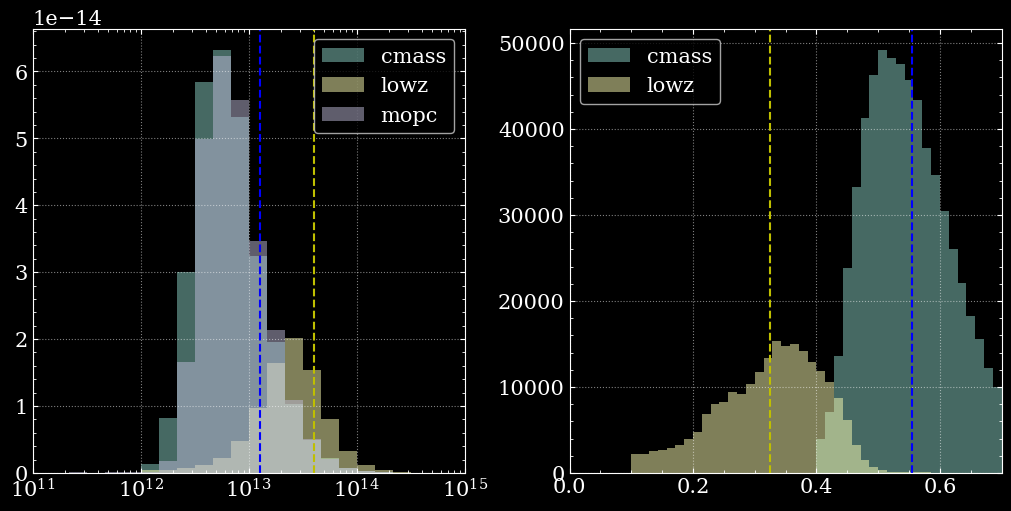

In [337]:
logms_cmass =dftestmara[(dftestmara["bits"].apply(lambda bits: (7 in bits))) &
                        (shmr.SHMR(dftestmara.LOGMASS)>12) & (dftestmara.Z>0.4)]
logms_lowz = dftestwisc[(dftestwisc["bits"].apply(lambda bits: (0 in bits))) & 
                        (shmr.SHMR(dftestwisc.MSTELLAR_MEDIAN)>12) & (dftestwisc.Z>0.1)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')

axs[0].hist(10**shmr.SHMR(logms_cmass.LOGMASS), bins=np.logspace(11, 15, 25), label='cmass', alpha=0.5, density=True);
axs[0].hist(10**shmr.SHMR(logms_lowz.MSTELLAR_MEDIAN), bins=np.logspace(11, 15, 25), label='lowz', alpha=0.5, density=True);
axs[0].hist(10**mopc_logmhalos, bins=np.logspace(11, 15, 25), label='mopc', alpha=0.5, density=True);


axs[0].axvline(10**shmr.SHMR(logms_cmass.LOGMASS.mean()), ls='--', c='blue')
axs[0].axvline(10**shmr.SHMR(logms_lowz.MSTELLAR_MEDIAN.mean()), ls='--', c='y')

axs[0].set(xlim=(1e11, 1e15), xscale='log')
axs[0].legend()


axs[1].hist(logms_cmass.Z, bins=np.linspace(0, 0.7, 50), label='cmass', alpha=0.5);
axs[1].hist(logms_lowz.Z, bins=np.linspace(0, 0.7, 50), label='lowz', alpha=0.5);

axs[1].axvline(logms_cmass.Z.mean(), ls='--', c='blue')
axs[1].axvline(logms_lowz.Z.mean(), ls='--', c='y')

axs[1].set(xlim=(0, 0.7))
axs[1].legend()

In [343]:
mopc_logmhalos

array([12.88014519, 13.35407476, 12.86155857, ..., 12.84307884,
       12.73448927, 13.13065035])

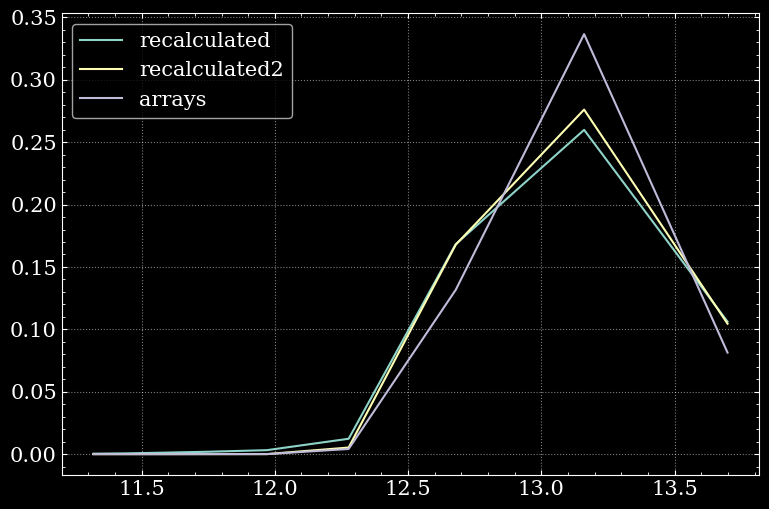

In [352]:
logms_cmass =dftestmara[(dftestmara["bits"].apply(lambda bits: (1 in bits)))]
h, b_edges = np.histogram(logms_cmass.LOGMASS, bins=np.linspace(9.42, 11.73, 10))
b_cen = np.array([(b_edges[i]+b_edges[i-1])*0.5 for i in range(1,len(b_edges))])
b_len = np.array([(b_edges[i]-b_edges[i-1]) for i in range(1,len(b_edges))])
integ = np.sum(10**b_len*h)
p = h/integ
plt.plot(shmr.SHMR(b_cen), p, label='recalculated')

h, b_edges = np.histogram(shmr.HSMR(mopc_logmhalos), bins=np.linspace(9.42, 11.73, 10))
b_cen = np.array([(b_edges[i]+b_edges[i-1])*0.5 for i in range(1,len(b_edges))])
b_len = np.array([(b_edges[i]-b_edges[i-1]) for i in range(1,len(b_edges))])
integ = np.sum(10**b_len*h)
p = h/integ
plt.plot(shmr.SHMR(b_cen), p, label='recalculated2')


plt.plot(mopc_logmhalo, mopc_N, label='arrays')
plt.legend()

In [10]:
p

array([1.04087299e-05, 1.01113376e-04, 3.47012185e-02, 1.54896770e-01,
       1.08353391e-01, 3.04157957e-02, 5.58502707e-03, 5.96271527e-04,
       2.52783440e-05])

In [5]:
np.mean(mopc_logmhalo)

13.142377092032541

In [223]:
import Models.SMFs as SMFs
del sys.modules['Models.SMFs']
import Models.SMFs as SMFs

In [235]:
cmass = SMFs.DR10CMASS({'group':'portsmouth', 'template':'passive', 'IMF':'krou'})

In [ ]:
np.sum(np.sum(cmass.N, axis=0)/np.sum(cmass.N)*cmass.logmstar)

array([1.01193829e-07, 3.82737001e-08, 2.42438412e-08, 1.90467149e-08,
       1.67808347e-08, 1.58430894e-08, 1.56449179e-08, 1.59286215e-08,
       1.65686106e-08, 1.75000472e-08, 1.86891563e-08])

In [ ]:
np.trapz(np.sum(cmass.dndlogm(**cpars)*cmass.volumes(**cpars)[:, ], axis=0), cmass.logmstar)

933157.500000001

In [231]:
cmass.logmstar

array([ 8.05,  8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,  8.85,
        8.95,  9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,  9.75,
        9.85,  9.95, 10.05, 10.15, 10.25, 10.35, 10.45, 10.55, 10.65,
       10.75, 10.85, 10.95, 11.05, 11.15, 11.25, 11.35, 11.45, 11.55,
       11.65, 11.75, 11.85, 11.95, 12.05, 12.15, 12.25, 12.35, 12.45,
       12.55, 12.65, 12.75, 12.85, 12.95, 13.05, 13.15, 13.25, 13.35,
       13.45, 13.55, 13.65, 13.75, 13.85, 13.95])

In [218]:
desi = SMFs.DESI1Percent({'zbin':'bin_4', 'sample':'LRG', 'hemisphere':'combined', 'zweight':'False'})

In [ ]:
cmass.addcuts(mstarmin=8)

In [221]:
np.sum(desi.N(**cpars))

17592.571984230664

In [208]:
cpars = {'hh':0.7,"T_CMB":2.7,"Omega_m":0.3,"Omega_b":0.05,"Omega_L":0.7}

In [245]:
np.genfromtxt("/global/homes/c/cpopik/Capybara/Data/cov_diskring_tsz_varweight_bootstrap.txt").shape

(9, 9)

(None, <matplotlib.legend.Legend at 0x7f7720146e00>)

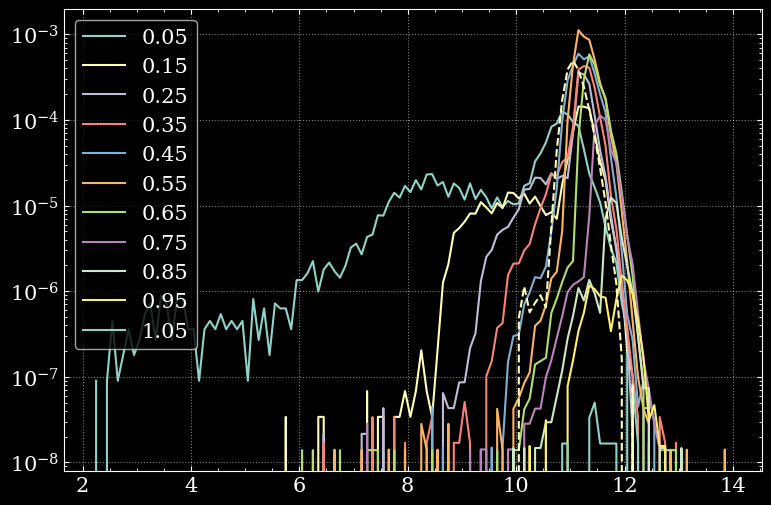

In [212]:
for i in range(cmass.z.size):
    plt.plot(cmass.logmstar, cmass.dndlogm(**cpars)[i], label=f'{cmass.z[i]:.2f}')

plt.plot(desi.logmstar, desi.dndlogmstar(**cpars)[4], ls='--')
plt.yscale('log'), plt.legend()

In [170]:
(cmass.area/4*np.pi*(180/np.pi)**2)

16432085.78967493

In [86]:
(2*np.pi*u.sr).to(u.deg**2)

<Quantity 20626.48062471 deg2>

In [83]:
np.sum(smf.n_to_N(0.7, 2.7, 0.3, 0.7, 0.05)[:, None]*smf.dndlogmstar)*0.7**3

5183897.788164904

In [39]:
pd.read_csv(f"{smf.path}/Fig1_{smf.sample}_z0.8.txt", sep=' ', names=['Mstar',f"n", f"err"], usecols=[0]).Mstar.values

array([ 7.05,  7.15,  7.25,  7.35,  7.45,  7.55,  7.65,  7.75,  7.85,
        7.95,  8.05,  8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,
        8.85,  8.95,  9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,
        9.75,  9.85,  9.95, 10.05, 10.15, 10.25, 10.35, 10.45, 10.55,
       10.65, 10.75, 10.85, 10.95, 11.05, 11.15, 11.25, 11.35, 11.45,
       11.55, 11.65, 11.75, 11.85, 11.95, 12.05, 12.15, 12.25, 12.35,
       12.45, 12.55, 12.65, 12.75, 12.85, 12.95])

In [32]:
np.trapz(smf.dndlogmstar, smf.logmsstar)

ValueError: operands could not be broadcast together with shapes (1,58) (6,59) 